# Introduction

**Introduction:**
VizWiz-Captions is an image captioning dataset to represent the use case of blind individuals relying on image captioning services. The dataset consists of 39181 images and each image in this dataset originates from people who are blind, and pairs with 5 corresponding captions. We use this dataset to create models to eliminate accessibility barriers for blind people.

**Problem Statement:**
The primary objective of this project is to design a machine learning model
that can accurately generate textual descriptions for images taken by visually impaired individuals. The aim of this project is to integrate deep learning techniques in computer vision and natural language processing, utilizing PyTorch and Tensorflow to develop and fine-tune models that can understand the complex relationships between image features and descriptive text.

**Motivation:**
The main motivation behind this project is to leverage our technical knowledge in Deep Learning and Neural Networks to build a robust model that enhances the utility of image captioning systems and can help in aiding visually impaired individuals to understand and interact with their environment through accurate image descriptions.



# Installation of Python Libraries
All required libraries for data pre-processing and model creation are installed.


*   Pandas, Numpy, and Matplotlib are used for data pre-processing, Exploratory Data Analysis(EDA), and plot visualisations.
*   Pytorch, Tensorflow and Transformers modules are used for creating and training the image captioning model.
*   The acc-metrics libraries are used to calculate the BLEU score, METEOR scores, CIDEr score, ROUGE score in order to get accurate results.

In [ ]:
!pip install aac-metrics
!aac-metrics-download
!pip install -U transformers

2024-11-16 12:33:49.044266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 12:33:49.191829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 12:33:49.228854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 12:33:54.177989: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2024-11-16 12:34:00,824][aac_metrics.download][INFO] - aac-metrics download started.
[2024-11-16 12:34:00,832][aac_metrics.download][INFO] - Stanford model file 'stanford_nlp' is already downloaded.
[2024-11-16 12:34:00,833][aac_metrics.dow

In [ ]:
# Install required libraries for data-preprocessing and model creation
from google.colab import drive
import json
import random
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.optim import AdamW
from transformers import BlipProcessor, BlipForConditionalGeneration, DataCollatorWithPadding, get_linear_schedule_with_warmup
import torch
from torch.amp import GradScaler, autocast
from keras.utils import to_categorical, plot_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from aac_metrics import evaluate

# Mount Drive location
drive.mount("/content/drive")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing VizWiz API

VizWiz API is provided by the VizWiz dataset challenge that gives us some helper functions for accessing the dataset easily.

In [ ]:
__author__ = 'nilavra'
__version__ = '1.0'
# Interface for accessing the VizWiz dataset.

# The codebase is adapted from Microsoft COCO Python API (http://cocodataset.org)
# https://github.com/cocodataset/cocoapi

# VizWiz is an image dataset originating from people who are blind, which is
# designed for Visual Question Answering, caption generation, and a host of
# other tasks. The VizWiz API assists in loading, parsing and visualizing the
# annotations in VizWiz. # Please visit http://vizwiz.org for more information
# on VizWiz, including # for the data, paper, and tutorials. The exact format
# of the annotations # is also described on the VizWiz website. In addition
# to this API, please download both the VizWiz images and annotations in order
# to run the demo.

# The following API functions are defined:
#  VizWiz     - VizWiz api class that loads VizWiz annotation file and prepare data structures.
#  getImgIds  - Get img ids that satisfy given filter conditions.
#  loadImgs   - Load imgs with the specified ids.
#  getAnnIds  - Get ann ids that satisfy given filter conditions.
#  loadAnns   - Load anns with the specified ids.
#  showAnns   - Display the specified annotations.
#  loadRes    - Load algorithm results and create API for accessing them.
#  download   - Download COCO images from mscoco.org server.

# The following API functions are also available:
#  getCatIds  - Get cat ids that satisfy given filter conditions.
#  loadCats   - Load cats with the specified ids.

# The following API functions were present in the original COCO API, but they
# have not been implemented here
#  decodeMask - Decode binary mask M encoded via run-length encoding.
#  encodeMask - Encode binary mask M using run-length encoding.
#  annToMask  - Convert segmentation in an annotation to binary mask.

# Throughout the API "ann"=annotation, "img"=image, and "cat"=category,.

# VizWiz API Version 1.0
# Data, paper, and tutorials available at:  http://vizwiz.org
# Code written by Nilavra Bhattacharya, 2019.
# Licensed under the Creative Commons Attribution 4.0 International License (CC BY 4.0)
# https://creativecommons.org/licenses/by/4.0


import json
import time
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import numpy as np
import copy
import itertools
#from . import mask as maskUtils
import os
from collections import defaultdict
import sys
PYTHON_VERSION = sys.version_info[0]
if PYTHON_VERSION == 2:
    from urllib import urlretrieve
elif PYTHON_VERSION == 3:
    from urllib.request import urlretrieve


def _isArrayLike(obj):
    return hasattr(obj, '__iter__') and hasattr(obj, '__len__')


class VizWiz:
    def __init__(self, annotation_file=None, ignore_rejected=True, ignore_precanned=True):
        """
        Constructor of VizWiz helper class for reading and visualizing annotations.
        :param annotation_file (str): location of annotation file
        :param image_folder (str): location to the folder that hosts images.
        :return:
        """
        # load dataset
        self.dataset,self.anns,self.cats,self.imgs = dict(),dict(),dict(),dict()
        self.imgToAnns, self.catToImgs = defaultdict(list), defaultdict(list)
        if not annotation_file == None:
            print('loading annotations into memory...')
            tic = time.time()
            dataset = json.load(open(annotation_file, 'r'))
            assert type(dataset) == dict, 'annotation file format {} not supported'.format(type(dataset))
            self.dataset = {}
            for key, value in dataset.items():
                if key != 'annotations':
                    self.dataset[key] = value
            self.dataset['annotations'] = []
            for annotation in dataset['annotations']:
                if (ignore_rejected and annotation['is_rejected']) \
                    or (ignore_precanned and annotation['is_precanned']):
                    continue
                else:
                    self.dataset['annotations'].append(annotation)

            print('Done (t={:0.2f}s)'.format(time.time()- tic))
            #self.dataset = dataset
            self.createIndex()

    def createIndex(self):
        # create index
        print('creating index...')
        anns, cats, imgs = {}, {}, {}
        imgToAnns,catToImgs = defaultdict(list),defaultdict(list)
        if 'annotations' in self.dataset:
            for ann in self.dataset['annotations']:
                imgToAnns[ann['image_id']].append(ann)
                anns[ann['id']] = ann

        if 'images' in self.dataset:
            for img in self.dataset['images']:
                imgs[img['id']] = img

        if 'categories' in self.dataset:
            for cat in self.dataset['categories']:
                cats[cat['id']] = cat

        if 'annotations' in self.dataset and 'categories' in self.dataset:
            for ann in self.dataset['annotations']:
                catToImgs[ann['category_id']].append(ann['image_id'])

        # create class members
        self.anns = anns
        self.imgToAnns = imgToAnns
        self.catToImgs = catToImgs
        self.imgs = imgs
        self.cats = cats

        print('index created! imgs = %d, anns = %d'
              % (len(self.imgs), len(self.anns))
        )

    def info(self):
        """
        Print information about the annotation file.
        :return:
        """
        for key, value in self.dataset['info'].items():
            print('{}: {}'.format(key, value))

    def getAnnIds(self, imgIds=[], catIds=[], areaRng=[], iscrowd=None):
        """
        Get ann ids that satisfy given filter conditions. default skips that filter
        :param imgIds  (int array)     : get anns for given imgs
               catIds  (int array)     : get anns for given cats
               areaRng (float array)   : get anns for given area range (e.g. [0 inf])
               iscrowd (boolean)       : get anns for given crowd label (False or True)
        :return: ids (int array)       : integer array of ann ids
        """
        imgIds = imgIds if _isArrayLike(imgIds) else [imgIds]
        catIds = catIds if _isArrayLike(catIds) else [catIds]

        if len(imgIds) == len(catIds) == len(areaRng) == 0:
            anns = self.dataset['annotations']
        else:
            if not len(imgIds) == 0:
                lists = [self.imgToAnns[imgId] for imgId in imgIds if imgId in self.imgToAnns]
                anns = list(itertools.chain.from_iterable(lists))
            else:
                anns = self.dataset['annotations']
            anns = anns if len(catIds)  == 0 else [ann for ann in anns if ann['category_id'] in catIds]
            anns = anns if len(areaRng) == 0 else [ann for ann in anns if ann['area'] > areaRng[0] and ann['area'] < areaRng[1]]
        if not iscrowd == None:
            ids = [ann['id'] for ann in anns if ann['iscrowd'] == iscrowd]
        else:
            ids = [ann['id'] for ann in anns]
        return ids

    def getCatIds(self, catNms=[], supNms=[], catIds=[]):
        """
        filtering parameters. default skips that filter.
        :param catNms (str array)  : get cats for given cat names
        :param supNms (str array)  : get cats for given supercategory names
        :param catIds (int array)  : get cats for given cat ids
        :return: ids (int array)   : integer array of cat ids
        """
        catNms = catNms if _isArrayLike(catNms) else [catNms]
        supNms = supNms if _isArrayLike(supNms) else [supNms]
        catIds = catIds if _isArrayLike(catIds) else [catIds]

        if len(catNms) == len(supNms) == len(catIds) == 0:
            cats = self.dataset['categories']
        else:
            cats = self.dataset['categories']
            cats = cats if len(catNms) == 0 else [cat for cat in cats if cat['name']          in catNms]
            cats = cats if len(supNms) == 0 else [cat for cat in cats if cat['supercategory'] in supNms]
            cats = cats if len(catIds) == 0 else [cat for cat in cats if cat['id']            in catIds]
        ids = [cat['id'] for cat in cats]
        return ids

    def getImgIds(self, imgIds=[], catIds=[]):
        '''
        Get img ids that satisfy given filter conditions.
        :param imgIds (int array) : get imgs for given ids
        :param catIds (int array) : get imgs with all given cats
        :return: ids (int array)  : integer array of img ids
        '''
        imgIds = imgIds if _isArrayLike(imgIds) else [imgIds]
        catIds = catIds if _isArrayLike(catIds) else [catIds]

        if len(imgIds) == len(catIds) == 0:
            ids = self.imgs.keys()
        else:
            ids = set(imgIds)
            for i, catId in enumerate(catIds):
                if i == 0 and len(ids) == 0:
                    ids = set(self.catToImgs[catId])
                else:
                    ids &= set(self.catToImgs[catId])
        return list(ids)

    def loadAnns(self, ids=[]):
        """
        Load anns with the specified ids.
        :param ids (int array)       : integer ids specifying anns
        :return: anns (object array) : loaded ann objects
        """
        if _isArrayLike(ids):
            return [self.anns[id] for id in ids]
        elif type(ids) == int:
            return [self.anns[ids]]

    def loadCats(self, ids=[]):
        """
        Load cats with the specified ids.
        :param ids (int array)       : integer ids specifying cats
        :return: cats (object array) : loaded cat objects
        """
        if _isArrayLike(ids):
            return [self.cats[id] for id in ids]
        elif type(ids) == int:
            return [self.cats[ids]]

    def loadImgs(self, ids=[]):
        """
        Load anns with the specified ids.
        :param ids (int array)       : integer ids specifying img
        :return: imgs (object array) : loaded img objects
        """
        if _isArrayLike(ids):
            return [self.imgs[id] for id in ids]
        elif type(ids) == int:
            return [self.imgs[ids]]

    def showAnns(self, anns):
        """
        Display the specified annotations.
        :param anns (array of object): annotations to display
        :return: None
        """
        if len(anns) == 0:
            return 0
        if 'segmentation' in anns[0] or 'keypoints' in anns[0]:
            datasetType = 'instances'
        elif 'caption' in anns[0]:
            datasetType = 'captions'
        else:
            raise Exception('datasetType not supported')

        if datasetType == 'captions':
            for ann in anns:
                print(ann['caption'])

        #####################################################
        # implement other annotation types as needed below
        #####################################################
        """
        elif datasetType == 'instances':

            ax = plt.gca()
            ax.set_autoscale_on(False)
            polygons = []
            color = []
            for ann in anns:
                c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
                if 'segmentation' in ann:
                    if type(ann['segmentation']) == list:
                        # polygon
                        for seg in ann['segmentation']:
                            poly = np.array(seg).reshape((int(len(seg)/2), 2))
                            polygons.append(Polygon(poly))
                            color.append(c)
                    else:
                        # mask
                        t = self.imgs[ann['image_id']]
                        if type(ann['segmentation']['counts']) == list:
                            rle = maskUtils.frPyObjects([ann['segmentation']], t['height'], t['width'])
                        else:
                            rle = [ann['segmentation']]
                        m = maskUtils.decode(rle)
                        img = np.ones( (m.shape[0], m.shape[1], 3) )
                        if ann['iscrowd'] == 1:
                            color_mask = np.array([2.0,166.0,101.0])/255
                        if ann['iscrowd'] == 0:
                            color_mask = np.random.random((1, 3)).tolist()[0]
                        for i in range(3):
                            img[:,:,i] = color_mask[i]
                        ax.imshow(np.dstack( (img, m*0.5) ))
                if 'keypoints' in ann and type(ann['keypoints']) == list:
                    # turn skeleton into zero-based index
                    sks = np.array(self.loadCats(ann['category_id'])[0]['skeleton'])-1
                    kp = np.array(ann['keypoints'])
                    x = kp[0::3]
                    y = kp[1::3]
                    v = kp[2::3]
                    for sk in sks:
                        if np.all(v[sk]>0):
                            plt.plot(x[sk],y[sk], linewidth=3, color=c)
                    plt.plot(x[v>0], y[v>0],'o',markersize=8, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
                    plt.plot(x[v>1], y[v>1],'o',markersize=8, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)
            p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        """

    def loadRes(self, resFile):
        """
        Load result file and return a result api object.
        :param   resFile (str)     : file name of result file
        :return: res (obj)         : result api object
        """
        res = VizWiz()
        res.dataset['images'] = [img for img in self.dataset['images']]

        print('Loading and preparing results...')
        tic = time.time()
        if type(resFile) == str or type(resFile) == bytes:
            anns = json.load(open(resFile))
        elif type(resFile) == np.ndarray:
            anns = self.loadNumpyAnnotations(resFile)
        else:
            anns = resFile
        assert type(anns) == list, 'results in not an array of objects'
        annsImgIds = [ann['image_id'] for ann in anns]
        assert set(annsImgIds) == (set(annsImgIds) & set(self.getImgIds())), \
            'Results do not correspond to current VizWiz set'
        if 'caption' in anns[0]:
            imgIds = set([img['id'] for img in res.dataset['images']]) & set([ann['image_id'] for ann in anns])
            res.dataset['images'] = [img for img in res.dataset['images'] if img['id'] in imgIds]
            for id, ann in enumerate(anns):
                ann['id'] = id+1

        #####################################################
        # implement other annotation types as needed below
        #####################################################
        """
        elif 'bbox' in anns[0] and not anns[0]['bbox'] == []:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                bb = ann['bbox']
                x1, x2, y1, y2 = [bb[0], bb[0]+bb[2], bb[1], bb[1]+bb[3]]
                if not 'segmentation' in ann:
                    ann['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
                ann['area'] = bb[2]*bb[3]
                ann['id'] = id+1
                ann['iscrowd'] = 0
        elif 'segmentation' in anns[0]:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                # now only support compressed RLE format as segmentation results
                ann['area'] = maskUtils.area(ann['segmentation'])
                if not 'bbox' in ann:
                    ann['bbox'] = maskUtils.toBbox(ann['segmentation'])
                ann['id'] = id+1
                ann['iscrowd'] = 0
        elif 'keypoints' in anns[0]:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                s = ann['keypoints']
                x = s[0::3]
                y = s[1::3]
                x0,x1,y0,y1 = np.min(x), np.max(x), np.min(y), np.max(y)
                ann['area'] = (x1-x0)*(y1-y0)
                ann['id'] = id + 1
                ann['bbox'] = [x0,y0,x1-x0,y1-y0]
        """

        print('DONE (t={:0.2f}s)'.format(time.time()- tic))

        res.dataset['annotations'] = anns
        res.createIndex()
        return res

    def download(self, tarDir = None, imgIds = [] ):
        '''
        Download VizWiz images from vizwiz.org server.
        :param tarDir (str): VizWiz results directory name
               imgIds (list): images to be downloaded
        :return:
        '''
        if tarDir is None:
            print('Please specify target directory')
            return -1
        if len(imgIds) == 0:
            imgs = self.imgs.values()
        else:
            imgs = self.loadImgs(imgIds)
        N = len(imgs)
        if not os.path.exists(tarDir):
            os.makedirs(tarDir)
        for i, img in enumerate(imgs):
            tic = time.time()
            fname = os.path.join(tarDir, img['file_name'])
            if not os.path.exists(fname):
                urlretrieve(img['vizwiz_url'], fname)
            print('downloaded {}/{} images (t={:0.1f}s)'.format(i, N, time.time()- tic))

    def loadNumpyAnnotations(self, data):
        """
        Convert result data from a numpy array [Nx7] where each row contains {imageID,x1,y1,w,h,score,class}
        :param  data (numpy.ndarray)
        :return: annotations (python nested list)
        """
        print('Converting ndarray to lists...')
        assert(type(data) == np.ndarray)
        print(data.shape)
        assert(data.shape[1] == 7)
        N = data.shape[0]
        ann = []
        for i in range(N):
            if i % 1000000 == 0:
                print('{}/{}'.format(i,N))
            ann += [{
                'image_id'  : int(data[i, 0]),
                'bbox'  : [ data[i, 1], data[i, 2], data[i, 3], data[i, 4] ],
                'score' : data[i, 5],
                'category_id': int(data[i, 6]),
            }]
        return ann

    def annToRLE(self, ann):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """

        """
        t = self.imgs[ann['image_id']]
        h, w = t['height'], t['width']
        segm = ann['segmentation']
        if type(segm) == list:
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, h, w)
            rle = maskUtils.merge(rles)
        elif type(segm['counts']) == list:
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, h, w)
        else:
            # rle
            rle = ann['segmentation']
        return rle
        """

    def annToMask(self, ann):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """

        """
        rle = self.annToRLE(ann)
        m = maskUtils.decode(rle)
        return m
        """


#Exploratory Data Analysis

##General Statistics

We verify that the VizWiz-Captions dataset includes:
* 23,431 training images
* 117,155 training captions
* 7,750 validation images
* 38,750 validation captions
* 8,000 test images
* 40,000 test captions

Note that the number of distinct images in training with is_precanned as True is 7680 and the number of distinct images in training with is_rejected as True is 2860, therefore we discard these images from the dataset, as explored later in the data cleaning section. Also note Kaggle did not provide the captions for the test set for the purposes of the competition.

In [ ]:
import json
import pandas as pd
import random
# For reproducability
random.seed(13)

# Load the Train Annotations and load the images and annotations (captions) into two Dataframes
train_annotation = json.load(open('/content/drive/MyDrive/annotations/train.json'))
train_img = pd.DataFrame(train_annotation['images'])
train_annot = pd.DataFrame(train_annotation['annotations'])
test_annotation = json.load(open('/content/drive/MyDrive/annotations/test.json'))
test_img = pd.DataFrame(test_annotation['images'])
val_annotation = json.load(open('/content/drive/MyDrive/annotations/val.json'))
val_img = pd.DataFrame(val_annotation['images'])
val_annot = pd.DataFrame(val_annotation['annotations'])
# No. images and captions in train
print("Number of distinct images in train:", train_annot['image_id'].nunique())
print("Number of captions in train:", len(train_annot))
# No. images and captions in test
print("Number of distinct images in test:", test_img['id'].nunique())
print("Number of captions in train:", len(val_img))
# No. images and captions in val
print("Number of distinct images in val:", val_img['id'].nunique())
print("Number of captions in val:", len(val_annot))
# Count distinct image IDs where is_precanned is True
print("Number of distinct images in training with is_precanned as True:", train_annot[train_annot['is_precanned'] == True]['image_id'].nunique())
# Count distinct image IDs where is_rejected is True
print("Number of distinct images in training with is_rejected as True:",  train_annot[train_annot['is_rejected'] == True]['image_id'].nunique())
print("Number of distinct images in training with text_detected as False:",  train_annot[((train_annot['text_detected'] == False) )]['image_id'].nunique())

print("Number of distinct images in training with is_rejected and is_precanned as True:",  train_annot[((train_annot['is_rejected'] == True) & (train_annot['is_precanned'] == True))]['image_id'].nunique())


Number of distinct images in train: 23431
Number of captions in train: 117155
Number of distinct images in test: 8000
Number of captions in train: 7750
Number of distinct images in val: 7750
Number of captions in val: 38750
Number of distinct images in training with is_precanned as True: 7680
Number of distinct images in training with is_rejected as True: 2860
Number of distinct images in training with text_detected as False: 12740
Number of distinct images in training with is_rejected and is_precanned as True: 1607


The training data has no missing values

In [ ]:
print("\nDataset Info:")
print(train_img.info())
print("\nDataset Info:")
print(train_annot.info())
# No missing values
print("\nMissing Values:")
print(train_img.isnull().sum())
print("\nMissing Values:")
print(train_annot.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23431 entries, 0 to 23430
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   file_name      23431 non-null  object
 1   vizwiz_url     23431 non-null  object
 2   id             23431 non-null  int64 
 3   text_detected  23431 non-null  bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 572.2+ KB
None

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117155 entries, 0 to 117154
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   caption        117155 non-null  object
 1   image_id       117155 non-null  int64 
 2   is_precanned   117155 non-null  bool  
 3   is_rejected    117155 non-null  bool  
 4   id             117155 non-null  int64 
 5   text_detected  117155 non-null  bool  
dtypes: bool(3), int64(2), object(1)
memory usage: 3.0+ MB
None

Missing Val

In [ ]:
# Train Images data
train_img.head(3)

file_name  \
0  VizWiz_train_00000000.jpg   
1  VizWiz_train_00000001.jpg   
2  VizWiz_train_00000002.jpg   

                                          vizwiz_url  id  text_detected  
0  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   0           True  
1  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   1           True  
2  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   2           True

In [ ]:
# Train Annotations data
train_annot.head(3)

caption  image_id  is_precanned  \
0  ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...         0         False   
1  A green and white plastic condiment bottle con...         0         False   
2  Quality issues are too severe to recognize vis...         0          True   

   is_rejected  id  text_detected  
0        False   0           True  
1        False   1           True  
2         True   2           True

In [ ]:
# Test images data
test_img.head(3)

file_name  \
0  VizWiz_test_00000000.jpg   
1  VizWiz_test_00000001.jpg   
2  VizWiz_test_00000002.jpg   

                                          vizwiz_url     id  text_detected  
0  https://ivc.ischool.utexas.edu/VizWiz_visualiz...  31181           True  
1  https://ivc.ischool.utexas.edu/VizWiz_visualiz...  31182          False  
2  https://ivc.ischool.utexas.edu/VizWiz_visualiz...  31183           True

## Image Exploration

As evident below, there are images present with quality issues, which in this dataset is also identified by either having the is_precanned or is_rejected value as true. The poor quality images presented a challenge for the model to train on and so these were not utilised.

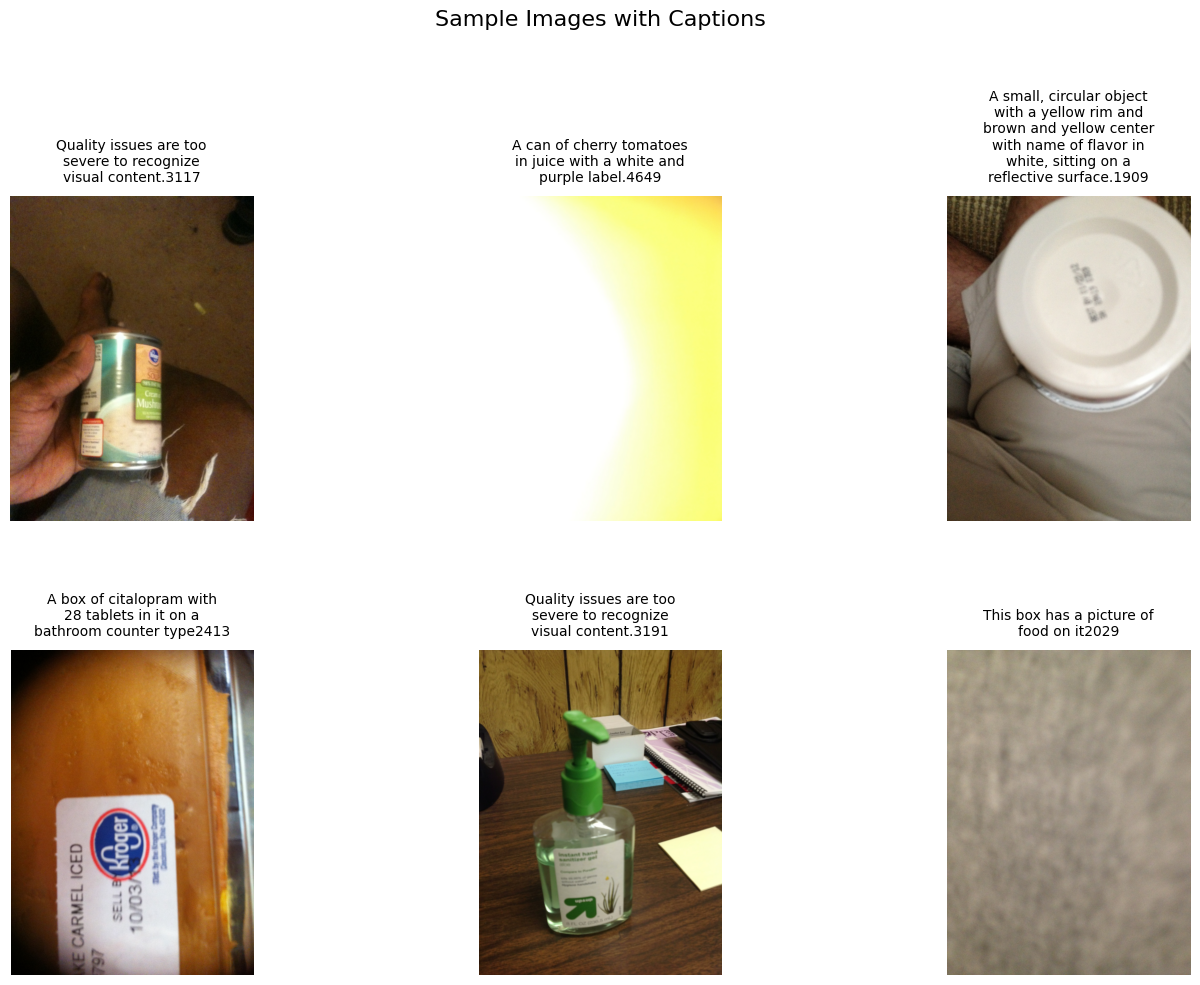

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from textwrap import wrap
left_join = pd.merge(df1, df2, on='id', how='left')
# Randomly select 6 images for preview
sample_images = left_join.sample(6, random_state=1)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
fig.suptitle("Sample Images with Captions", fontsize=16)
axes = axes.flatten()
for ax, (_, row) in zip(axes, sample_images.iterrows()):
    img = Image.open('/content/drive/MyDrive/train/' + row['file_name'])
    ax.imshow(img)
    ax.axis('off')
    caption = "\n".join(wrap(row['caption']+str(row['image_id']), width=25))
    ax.set_title(caption, fontsize=10, color="black", backgroundcolor="white", pad=10)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.4)
plt.show()

You can view the image information (such as is_precanned value) for the above images in the cell output below

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from textwrap import wrap
left_join = pd.merge(df1, df2, on='id', how='left')
# Randomly select 6 images for preview
sample_images = left_join.sample(6, random_state=1)
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
# fig.suptitle("Sample Images with Captions", fontsize=16)
# axes = axes.flatten()
for ax, (_, row) in zip(axes, sample_images.iterrows()):
    img = Image.open('/content/drive/MyDrive/train/' + row['file_name'])
    print(row)
    # ax.imshow(img)
    # ax.axis('off')
    # caption = "\n".join(wrap(row['caption']+str(row['image_id']), width=25))
    # ax.set_title(caption, fontsize=10, color="black", backgroundcolor="white", pad=10)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.subplots_adjust(hspace=0.4)
# plt.show()

file_name                                  VizWiz_train_00015585.jpg
vizwiz_url         https://ivc.ischool.utexas.edu/VizWiz_visualiz...
id                                                             15585
text_detected_x                                                 True
caption            Quality issues are too severe to recognize vis...
image_id                                                        3117
is_precanned                                                    True
is_rejected                                                    False
text_detected_y                                                False
Name: 15585, dtype: object
file_name                                  VizWiz_train_00023249.jpg
vizwiz_url         https://ivc.ischool.utexas.edu/VizWiz_visualiz...
id                                                             23249
text_detected_x                                                False
caption            A can of cherry tomatoes in juice with a white...
image_i

## Text Exploration

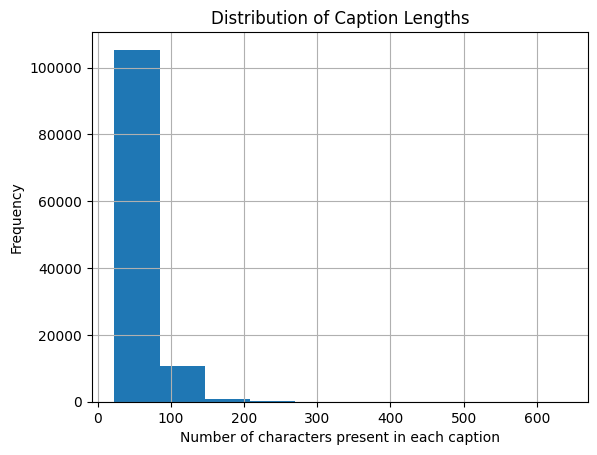

23
639


In [ ]:
# number of characters present in each sentence
import matplotlib.pyplot as plt
train_annot['caption'].str.len().hist()
plt.xlabel("Number of characters present in each caption")
plt.ylabel("Frequency")
plt.title("Distribution of Caption Lengths")
plt.show()
print(min(train_annot['caption'].str.len()))
print(max(train_annot['caption'].str.len()))

Caption lengths range from 23 to 639 characters, with most captions having roughly 25-80 characters per caption

# Data Preprocessing and Exploratory Data Analysis (EDA)


**Data Source:**
The Vizwiz Image Captioning Dataset is used as the data source to build the model. This has been downloaded from the official Vizwiz site: https://vizwiz.org/tasks-and-datasets/image-captioning/


**Data Pre-processing:**
To reduce the dimensionality and pre-processing time 10000 images are used to train the model. These images are extracted from the Training Dataset of 23,431, by filtering out precanned, poor quality images, and textual images. Key tasks performed for preprocessing:


*   Load image ID's, filenames and captions from vizwiz dataset annotations.
*   Filter out precanned and poor quality Images. Also filter out non-textual images.
*   Create the training and testing set using these filters, considering 10000 images for training and 2000 images for testing.



In [ ]:
# Load the Train Annotations and load the images and annotations (captions) into two Dataframes
train_annotation = json.load(open('/content/drive/MyDrive/annotations/train.json'))
df1 = pd.DataFrame(train_annotation['images'])
df2 = pd.DataFrame(train_annotation['annotations'])

# Reduce the Dataset size by filtering out images that are precanned and rejected
precanned_ids = df2.loc[(df2['is_precanned'] == True) | (df2['is_rejected'] == True), 'image_id']
df1_filtered = df1[~df1['id'].isin(precanned_ids)]
df1_filtered = df1_filtered[df1_filtered['text_detected']==True]
df2_filtered = df2[~df2['image_id'].isin(precanned_ids)]

# Create a Dataframe and save this to a csv file
df = pd.merge(df1_filtered, df2_filtered, left_on='id', right_on='image_id',how='inner')
df.rename(columns={'file_name':"image",'id_x':"id",'text_detected_x':'text_detected'}, inplace=True)
df.to_csv('train_data.csv', index=False)

df.head(5)

image  \
0  VizWiz_train_00000001.jpg   
1  VizWiz_train_00000001.jpg   
2  VizWiz_train_00000001.jpg   
3  VizWiz_train_00000001.jpg   
4  VizWiz_train_00000001.jpg   

                                          vizwiz_url  id  text_detected  \
0  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   1           True   
1  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   1           True   
2  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   1           True   
3  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   1           True   
4  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   1           True   

                                             caption  image_id  is_precanned  \
0  A can of Coca Cola on a counter is shown for w...         1         False   
1  A black can of Coca Cola Zero calorie soda is ...         1         False   
2  A kitchen counter the various items on top inc...         1         False   
3  a black tin of Coca Cola placed on a black sur...         1         False   
4  Black counter with canisters, kettle and can o...         1         False   

   is_rejected  id_y  text_detected_y  
0        False     5             True  
1        False     6             True  
2        False     7             True  
3        False     8             True  
4        False     9             True

In [ ]:
# Load the Test Annotations and load the images and annotations (captions) into two Dataframes
val_annotation = json.load(open('/content/drive/MyDrive/annotations/val.json'))
df1_test = pd.DataFrame(val_annotation['images'])
df2_test = pd.DataFrame(val_annotation['annotations'])

# Reduce the Test Dataset size by filtering out images that are precanned and rejected
precanned_ids = df2_test.loc[(df2_test['is_precanned'] == True) | (df2_test['is_rejected'] == True), 'image_id']
df1_filtered_test = df1_test[~df1_test['id'].isin(precanned_ids)]
df1_filtered_test = df1_filtered_test[df1_filtered_test['text_detected']==True]
df2_filtered_test = df2_test[~df2_test['image_id'].isin(precanned_ids)]

# Create a Dataframe and save this to a csv file
df_test = pd.merge(df1_filtered_test, df2_filtered_test, left_on='id', right_on='image_id',how='inner')
df_test.rename(columns={'file_name':"image",'id_x':"id",'text_detected_x':'text_detected'}, inplace=True)
df_test = df_test[:10000]
df_test.to_csv('/content/drive/MyDrive/annotations/val_data_2k.csv', index=False)

df_test.head(5)

image                                         vizwiz_url  \
0  VizWiz_val_00000000.jpg  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   
1  VizWiz_val_00000000.jpg  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   
2  VizWiz_val_00000000.jpg  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   
3  VizWiz_val_00000000.jpg  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   
4  VizWiz_val_00000000.jpg  https://ivc.ischool.utexas.edu/VizWiz_visualiz...   

      id  text_detected                                            caption  \
0  23431           True  A computer screen shows a repair prompt on the...   
1  23431           True  a computer screen with a repair automatically ...   
2  23431           True  partial computer screen showing the need of re...   
3  23431           True  Part of a computer monitor showing a computer ...   
4  23431           True  The top of a laptop with a blue background and...   

   image_id  is_precanned  is_rejected    id_y  text_detected_y  
0     23431         False        False  117155             True  
1     23431         False        False  117156             True  
2     23431         False        False  117157             True  
3     23431         False        False  117158             True  
4     23431         False        False  117159             True

Total Number of Training Images: 10553
Total Number of Test Images: 2000
Training Percentage: 84.07%
Testing Percentage: 15.93%


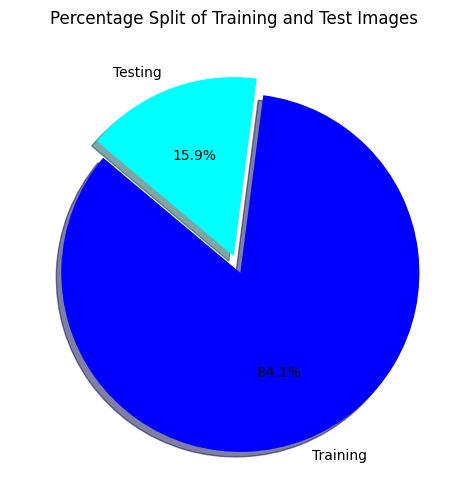

In [ ]:
# Calculate the number of unique training and testing images
train_unique_images = len(np.unique(df['image_id']))
test_unique_images = len(np.unique(df_test['id']))

# Calculate the percentage split of training and testing images
total_images = train_unique_images + test_unique_images
train_percentage = (train_unique_images / total_images) * 100
test_percentage = (test_unique_images / total_images) * 100

# Print out the Images
print("Total Number of Training Images:", train_unique_images)
print("Total Number of Test Images:", test_unique_images)
print("Training Percentage: {:.2f}%".format(train_percentage))
print("Testing Percentage: {:.2f}%".format(test_percentage))


# Create a pie chart showing the amount of training and testing images
labels = ['Training', 'Testing']
sizes = [train_percentage, test_percentage]
colors = ['blue', 'cyan']
explode = (0.1, 0)  # explode the first slice for emphasis

# Plotting the pie chart
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
ax.set_title('Percentage Split of Training and Test Images')

# Show the pie chart
plt.tight_layout()
plt.show()

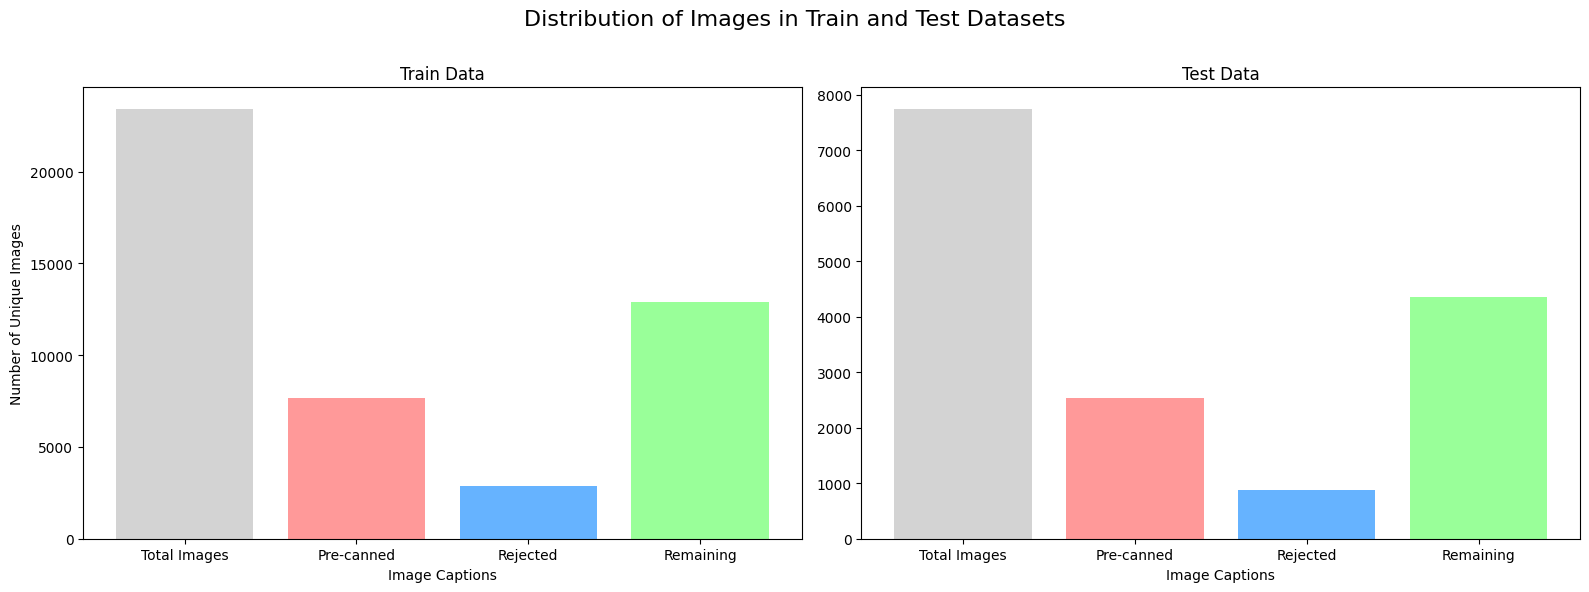

In [ ]:
# Show the distribution of Image captions with the count of total images, pre-canned captions, rejected captions in both the Training and Test Sets

# Train Data Calculations with unique image_id
total_images_train = df2['image_id'].nunique()
pre_canned_count_train = df2[df2['is_precanned'] == True]['image_id'].nunique()
rejected_count_train = df2[df2['is_rejected'] == True]['image_id'].nunique()
remaining_count_train = total_images_train - (pre_canned_count_train + rejected_count_train)

# Test Data Calculations with unique image_id
total_images_test = df2_test['image_id'].nunique()
pre_canned_count_test = df2_test[df2_test['is_precanned'] == True]['image_id'].nunique()
rejected_count_test = df2_test[df2_test['is_rejected'] == True]['image_id'].nunique()
remaining_count_test = total_images_test - (pre_canned_count_test + rejected_count_test)

# Data for the plot
train_counts = [total_images_train, pre_canned_count_train, rejected_count_train, remaining_count_train]
test_counts = [total_images_test, pre_canned_count_test, rejected_count_test, remaining_count_test]
labels = ['Total Images', 'Pre-canned', 'Rejected', 'Remaining']

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Train Data
axes[0].bar(labels, train_counts, color=['#d3d3d3', '#ff9999', '#66b3ff', '#99ff99'])
axes[0].set_title('Train Data')
axes[0].set_ylabel('Number of Unique Images')
axes[0].set_xlabel('Image Captions')

# Plot for Test Data
axes[1].bar(labels, test_counts, color=['#d3d3d3', '#ff9999', '#66b3ff', '#99ff99'])
axes[1].set_title('Test Data')
axes[1].set_xlabel('Image Captions')

# Adjust layout to make room for the titles
plt.tight_layout()
plt.suptitle("Distribution of Images in Train and Test Datasets", fontsize=16)
plt.subplots_adjust(top=0.85)  # Adjust the top margin to fit the title
plt.show()


# BLIP Model
BLIP is a model that is able to perform various multi-modal tasks including Image Captioning. The BLIP model has been pre-trained on a large, diverse multimodal dataset consisting of noisy image-text pairs from the web, which makes it optimal for image captioning. For this project, the BLIP Model is fine-tuned and trained on custom hyper-parameters to obtain optimal results. The results of the pre-trained BLIP Model is compared to the fine-tuned BLIP Model.

BLIP Components:

*   The BLIP processor uses BERT Tokenizer for a bi-directional approach which enables it to predict contextually accurate captions.  

*   BLIP Model for image captioning (BlipForConditionalGeneration) consists of a vision encoder and a text decoder, which replaces the bidirectional self-attention layers in the image-grounded text
encoder with causal self-attention layers.

In [ ]:
# Load the pre-trained BLIP model
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# Define a custom Dataset class for VizWiz
class VizWizDataset(Dataset):

    def __init__(self, data, image_folder, processor):
        self.data = data
        self.processor = processor
        self.image_folder = image_folder
        self.samples = []

        for _, row in self.data.iterrows():
                self.samples.append({
                    "caption": row["caption"],
                    "image": row["image"]
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        # Load image and caption
        caption = self.samples[idx]["caption"]

        image_file = os.path.join(self.image_folder, self.samples[idx]["image"])

        image = Image.open(image_file).convert("RGB")

        # Process image and caption
        inputs = self.processor(images=image, text=caption, return_tensors="pt")

        return {
            "pixel_values": inputs["pixel_values"].squeeze(),
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "caption": caption,
        }

# Get Training Images
img_folder_path='/content/drive/MyDrive/train'

# Create Training and Testing dataset from pre-processed annotations
train_data = df
test_data = df_test
train_dataset = VizWizDataset(train_data, img_folder_path, processor)
test_dataset = VizWizDataset(test_data, img_folder_path, processor)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
# Check if CUDA is available on the device
use_amp = torch.cuda.is_available()
print("Cuda Available?",use_amp)

# Use CUDA if it is available on the device
device = torch.device("cuda" if use_amp else "cpu")
model.to(device)

Cuda Available? False


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [ ]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

# Create a data collator with padding
data_collator = DataCollatorWithPadding(processor.tokenizer)

# Define a custom collate function to apply padding to all items to ensure they are of the same length.
def collate_fn(batch):
    batch = [item for item in batch if item is not None]  # Filter out empty items
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]

    # Apply padding to input_ids and attention_mask using the data_collator
    batch_encoding = data_collator(
        {"input_ids": input_ids, "attention_mask": attention_mask}
    )

    return {
        "pixel_values": pixel_values,
        "input_ids": batch_encoding["input_ids"],
        "attention_mask": batch_encoding["attention_mask"],
        "captions": [item["caption"] for item in batch]
    }

# Define Hyperparameters
batch_size = 8
num_epochs = 1
learning_rate =  1e-5

# Prepare DataLoader using Batches and padding for optimized processing
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


# Baseline BLIP model evaluation
To compare pre and post fine-tuning result, the BLIP pre-trained model is evaluated on the 2000 sample test images that have been collected while pre-processing test data. The results of this model is evaluated against BLEU1-4, METEOR, ROUGE, CIDEr, SPICE scores. These metrics are stored and later compared with the fine-tuned model.

In [ ]:
# Creating a list of Test data image ids and captions from pre-processed test annotations
eval_data=pd.read_csv('/content/drive/MyDrive/annotations/val_data_2k.csv')
samples=[]
ids=[]
data={}
ref_cap={}

# Create a list containing Ids, Captions, and Filenames of the 2000 test images
for _, row in eval_data.iterrows():
                samples.append({
                    "id":row['id'],
                    "caption": row["caption"],
                    "file_name": row["file_name"]
                })

# Map Id to captions to create a list of the original reference captions
for e in samples:
    if e['id'] in ref_cap:
      ref_cap[e['id']].append(e['caption'])
    else:
      ref_cap[e['id']]=[e['caption']]
    if e['id'] not in data:
      data[e['id']]=e['file_name']
      ids.append(e['id'])

print(len(ref_cap))

2000


In [ ]:
# Function to generate caption for an image using baseline BLIP model
def generate_caption(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")

    # Process the image and generate input
    inputs = processor(image, return_tensors="pt")

    # Generate caption using BLIP pre-trained model
    caption_ids = model.generate(**inputs,max_new_tokens=300)
    caption = processor.decode(caption_ids[0], skip_special_tokens=True)

    return caption

# Combine all reference captions for an image into a single list.
# As each image consits of 5 captions, all captions are combined into a single list for easy evaluation.
# Further all predicted captions made using BLIP are added into a single list for comparision with reference captions.
list_caption=[]
list_reference_caption=[]
for i in ids[:100]:
  if i in data and i in ref_cap:
    image = "/content/drive/MyDrive/val/"+data[i]
    # Predicted captions using pre-trained BLIP model and store these captions into a list
    caption=generate_caption(image)
    list_caption.append(caption.replace("\n", ""))

    # Fetch Reference caption of the image and store all reference captions into a single list for comparision with generated/predicted captions.
    temp_ref_cap = ref_cap[i]
    temp_ref_cap = [x.replace("\n", "") for x in temp_ref_cap]
    list_reference_caption.append(temp_ref_cap)


# Defining metrics variables for baseline BLIP model and fine-tuned model for later comparision.
blip_baseline_bleu_1 = 0
blip_baseline_meteor = 0
blip_baseline_rouge_l =0
blip_baseline_cider_d =0
blip_baseline_spice = 0

blip_fine_tuned_bleu_1 = 0
blip_fine_tuned_meteor = 0
blip_fine_tuned_rouge_l =0
blip_fine_tuned_cider_d =0
blip_fine_tuned_spice = 0

# Evaluate Pre-trained BLIP Model by Calculating the BLEU, METEOR, ROUGE, CIDEr and SPICE scores, by comparing the predicted and reference captions.
corpus_scores, _ = evaluate(list_caption,list_reference_caption)
blip_baseline_bleu_1 = corpus_scores['bleu_1'].item()
blip_baseline_meteor = corpus_scores['meteor'].item()
blip_baseline_rouge_l =corpus_scores['rouge_l'].item()
blip_baseline_cider_d =corpus_scores['cider_d'].item()
blip_baseline_spice = corpus_scores['spice'].item()
print("BLEU-1 score for default BLIP model: ", corpus_scores['bleu_1'].item())
print("BLEU-2 score for default BLIP model: ", corpus_scores['bleu_2'].item())
print("BLEU-3 score for default BLIP model: ", corpus_scores['bleu_3'].item())
print("BLEU-4 score for default BLIP model: ", corpus_scores['bleu_4'].item())
print("METEOR score for default BLIP model: ", corpus_scores['meteor'].item())
print("ROUGE-L score for default BLIP model: ", corpus_scores['rouge_l'].item())
print("CIDEr score for default BLIP model: ", corpus_scores['cider_d'].item())
print("SPICE score for default BLIP model: ", corpus_scores['spice'].item())

BLEU-1 score for default BLIP model:  0.6850669703414581
BLEU-2 score for default BLIP model:  0.48983295269566485
BLEU-3 score for default BLIP model:  0.34042044719267583
BLEU-4 score for default BLIP model:  0.24051181557571089
METEOR score for default BLIP model:  0.18597567030945486
ROUGE-L score for default BLIP model:  0.4501391597482955
CIDEr score for default BLIP model:  0.38190867459635586
SPICE score for default BLIP model:  0.1100000300784497


# Training/Fine-Tuning Baseline BLIP Model
The Pre-trained BLIP Model is fine-tuned using custom hyper-parameters and optimizers. Following are the hyper-parameters used:

*   Learning Rate = 1e-5
*   Batch Size = 8
*   Epochs = 1
*   Optimizer = Adam


Scheduler - used to set up a learning rate schedule for a more stable and effective training.
Gradscaler is also used for mixed precision training to scale the gradients and losses before backpropagation.


**Training Approach:**

*  Training is done by iterating throught the Train Dataloader using Forward and Backward propagation.
*  During each iteration, Forward propagation is done by feeding in pixel_values, input_ids, and attention_mask, from which the output loss is calculated.
*  Back propagation is then used to compute gradients of the loss and update the models parameteres using the computed gradients.








In [ ]:
# Fine-tune and train the model on custom hyperparameters

# Define the Hyperparameters, Optimizer, Data loader, Epochs and schedular
learning_rate =  1e-5
batch_size = 8
num_epochs = 1
optimizer = AdamW(model.parameters(), lr=learning_rate)
train_dataloader_len = len(train_dataloader)
total_steps = train_dataloader_len * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


# Initialize GradScaler for mixed precision scaing of parameters
scaler = GradScaler(device) if use_amp else None

# Train the model with the hyperparameters
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    print("Epoch:", epoch)

    # Iterate through each batch of the previously created train_dataloader for training
    for step, batch in enumerate(train_dataloader):
        if use_amp: # If GPU is present
            # Forward Pass. Move inputs to GPU
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            # Using autocase with CUDA device to speed up training process
            with autocast(device_type='cuda'):
                outputs = model(
                    pixel_values=pixel_values,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=input_ids
                )

                loss = outputs.loss # Compute loss
                total_loss += loss.item()

            # Backward pass and optimization
            scaler.scale(loss).backward() # Scale the loss to prevent underflow.
            scaler.step(optimizer) # Updates model parameters by adjusting them based on the scaled gradients.
            scaler.update() # Adjusts the scaling factor dynamically for the next iteration.
            scheduler.step() # Updates the model's parameters using the computed gradients.
            optimizer.zero_grad() # Clears the gradients of the model’s parameters for the next batch.

        else: # Run on CPU if GPU is not present
            pixel_values = batch["pixel_values"]
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]

            # Forward pass
            outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss  # Compute loss
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward() # Computes gradients of the loss with respect to model parameters.
            optimizer.step() # Updates the model's parameters using the computed gradients.
            optimizer.zero_grad()

        print("Step:",step,"/",train_dataloader_len,"; Loss:", loss.item(),"; GPU:",use_amp)


    # Log the average loss per epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / train_dataloader_len}")



In [ ]:
# Save the trained model and processor
model.save_pretrained("/content/drive/MyDrive/models/blip_fine_tuned_model")
processor.save_pretrained("/content/drive/MyDrive/models/blip_processor")


In [ ]:
# Display Model Architecture
print(model)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

# Model Evaluation/Discussion

The Model is evaluated against BLEU1-4, METEOR, ROUGE-L, CIDEr-D, and SPICE scores.

**Results:**

The below table demonstrates how fine tuning has increased the performance of the BLIP and ViT + GPT-2 models.


| Metric          | BLIP (Default)   | BLIP (Fine-tuned) | ViT + GPT-2 (Default) | ViT + GPT-2 (Fine-tuned) |
|-----------------|------------------|--------------------|------------------------|---------------------------|
| BLEU-1          | 0.6851           | 0.6818            | 0.6049                 | 0.6439                    |
| BLEU-2          | 0.4898           | 0.4953            | 0.4002                 | 0.4643                    |
| BLEU-3          | 0.3404           | 0.3538            | 0.2487                 | 0.3231                    |
| BLEU-4          | 0.2405           | 0.2536            | 0.1550                 | 0.2216                    |
| METEOR          | 0.1860           | 0.2081            | 0.1606                 | 0.1984                    |
| ROUGE-L         | 0.4501           | 0.4725            | 0.3984                 | 0.4494                    |
| CIDEr           | 0.3819           | 0.4703            | 0.2053                 | 0.4244                    |
| SPICE           | 0.1100           | 0.1426            | 0.0840                 | 0.1241                    |

**Discussion:**
Across BLEU-1 to BLEU-4 scores, the models exhibit varying abilities to generate accurate n-grams when compared to human annotations. Fine-tuning led to consistent improvements across all BLEU scores, which is indicated in the BLEU-4 score, corresponding to improved fluency and accuracy in longer phrases. The BLIP model, whether in its default or fine-tuned state, shows relatively high BLEU-1 and BLEU-2 scores, suggesting that it captures common unigrams and bigrams well. However, the BLEU-4 scores remain lower, which indicates limitations in generating complex or diverse expressions. The higher METEOR scores highlight that fine-tuning aids in capturing semantic meaning and synonymy, which aligns with the VizWiz dataset's need for adaptability to varied question formats and descriptions. The improved ROUGE-L score in fine-tuned models shows enhanced ability to maintain sequence similarity with reference answers, particularly for BLIP. Fine-tuning significantly improves CIDEr and SPICE scores for BLIP and ViT + GPT-2.

**BLIP Model Strengths:** The BLIP model consistently performs well on the BLEU, ROUGE-L, CIDEr, and SPICE scores. Its strength lies in its ability to capture detailed visual information and translate it into descriptive, semantically rich captions.

**ViT + GPT-2 Model Strengths:** ViT + GPT-2, especially after fine-tuning, achieves high BLEU-1 and BLEU-2 scores. This suggests that it captures basic structural elements of responses effectively and is responsive to straightforward descriptions.

**Weaknesses/Limitations:**
* Despite improvements with fine-tuning, both models struggle with BLEU-3 and BLEU-4 scores, indicating difficulty in generating fluent and contextually accurate longer phrases. This highlights a potential limitation in handling complex language constructs or sophisticated sentences requiring contextual understanding
* While the fine-tuned BLIP model shows improved SPICE scores, its weakness lies in its inability to achieve high semantic understanding comparable to human-level descriptions. This is due to the model's reliance on minimum understanding as opposed to an in depth comprehension of relationships between objects in the image.
* VizWiz Dataset limitations such as variability in lighting conditions, inconsistencies in image quality and contextual ambiguity, affects model performance. For a model trained on  in capturing and communicating details through captioning.
* Limitations in computational power decreased the capacity for training models on the whole image dataset and therefore we required selecting a subset of the original data.

**Future Improvements:**

* Further fine-tuning on a larger subset of VizWiz-specific images and captions can help both models better capture the intricacies of this dataset. This approach could also involve adaptive training that focuses on common visual or linguistic patterns found in VizWiz, such as handling out-of-focus images.
* Alternative methods such as multimodal transformers or improved attention mechanisms that prioritize essential visual details and semantic meaning could be utilised to analyse and acccount for contextual information.
* Looking to specifically preprocess images based on the features of the image which need to be enhanced may allow for more accurate prediction and could be an avenue of improvement.

## BLIP Model Evaluation
The  Trained BLIP Model is compared with the Fine-tuned BLIP Model on BLEU, METEOR, CIDEr, ROUGE, and SPICE Scores.
Captions are generated using the fine-tuned BLIP Model for 10 random test image samples. These generated captions are compared with the reference captions. Images for these generated captions are displayed along with the Reference captions and Scores.

In [ ]:
# Load the fine-tuned model and processor
model_fine_tuned = BlipForConditionalGeneration.from_pretrained("/content/drive/MyDrive/models/blip_fine_tune_model")
processor_fine_tuned = BlipProcessor.from_pretrained("/content/drive/MyDrive/models/blip_processor/")

# Count the total and trainable parameters in the pre-trained BLIP Model
total_params = sum(p.numel() for p in model.parameters())

# Load the fine-tuned model and processor
trainable_params = sum(p.numel() for p in model_fine_tuned.parameters() if p.requires_grad)

print(f"Total parameters in BLIP model: {total_params}")
print(f"Total Parameters in fine-tuned BLIP Model: {trainable_params}")
print(f"Percentage of parameters fine-tuned: {(trainable_params / total_params) * 100:.2f}%")


Total parameters in BLIP model: 247414076
Total Parameters in fine-tuned BLIP Model: 247414076
Percentage of parameters fine-tuned: 100.00%


In [ ]:
# Function to generate caption for an image using fine-tuned BLIP model
def generate_caption1(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")

    # Process the image and generate input
    inputs = processor_fine_tuned(image, return_tensors="pt")

    # Generate caption using BLIP
    caption_ids = model_fine_tuned.generate(**inputs,max_new_tokens=300)
    caption = processor_fine_tuned.decode(caption_ids[0], skip_special_tokens=True)

    return caption

list_caption=[]
list_reference_caption=[]

for i in ids[:100]:
  if i in data and i in ref_cap:
    image = "/content/drive/MyDrive/val/"+data[i]

    # Predicted captions using fine-tuned BLIP model and store these captions into a list
    caption=generate_caption1(image)
    list_caption.append(caption.replace("\n", ""))

    # Fetch Reference caption of the image and store all reference captions into a single list for comparision with predicted captions.
    temp_ref_cap = ref_cap[i]
    temp_ref_cap = [x.replace("\n", "") for x in temp_ref_cap]
    list_reference_caption.append(temp_ref_cap)



In [ ]:
# Evaluate fine-tuned BLIP Model by Calculating the BLEU, METEOR, ROUGE, CIDEr and SPICE scores.
corpus_scores, _ = evaluate(list_caption,list_reference_caption)
blip_fine_tuned_bleu_1 = corpus_scores['bleu_1'].item()
blip_fine_tuned_meteor = corpus_scores['meteor'].item()
blip_fine_tuned_rouge_l =corpus_scores['rouge_l'].item()
blip_fine_tuned_cider_d =corpus_scores['cider_d'].item()
blip_fine_tuned_spice = corpus_scores['spice'].item()
print("BLEU-1 score for fine-tuned BLIP model: ", corpus_scores['bleu_1'].item())
print("BLEU-2 score for fine-tuned BLIP model: ", corpus_scores['bleu_2'].item())
print("BLEU-3 score for fine-tuned BLIP model: ", corpus_scores['bleu_3'].item())
print("BLEU-4 score for fine-tuned BLIP model: ", corpus_scores['bleu_4'].item())
print("METEOR score for fine-tuned BLIP model: ", corpus_scores['meteor'].item())
print("ROUGE-L score for fine-tuned BLIP model: ", corpus_scores['rouge_l'].item())
print("CIDEr score for fine-tuned BLIP model: ", corpus_scores['cider_d'].item())
print("SPICE score for fine-tuned BLIP model: ", corpus_scores['spice'].item())

BLEU-1 score for fine-tuned BLIP model:  0.68177613320936
BLEU-2 score for fine-tuned BLIP model:  0.49530617907741864
BLEU-3 score for fine-tuned BLIP model:  0.3537715485443208
BLEU-4 score for fine-tuned BLIP model:  0.2536355550047776
METEOR score for fine-tuned BLIP model:  0.2080757665550644
ROUGE-L score for fine-tuned BLIP model:  0.4724608491957518
CIDEr score for fine-tuned BLIP model:  0.47026994510687214
SPICE score for fine-tuned BLIP model:  0.14256950290085207


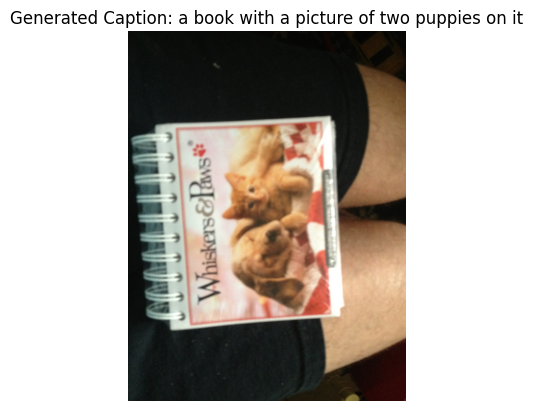

Generated Caption: a book with a picture of two puppies on it
Reference Caption: ["The top side of a whiskers and paws book on a man's lap", 'A spiral bound book with a dog and cat on the cover, titled whiskers and paws.', "A flip book with a dog and cat on it and says Whiskers and Paws on it sitting on someone's lap.", "A calendar for cats and dogs sitting on a person's lap.", 'A book with large binding and a cat and dog on the front.']
BLEU-1 score :  0.5731115270399652
METEOR score :  0.13564068092688272
ROUGE-L score :  0.45096106456382457
SPICE score :  0.044444444444444446



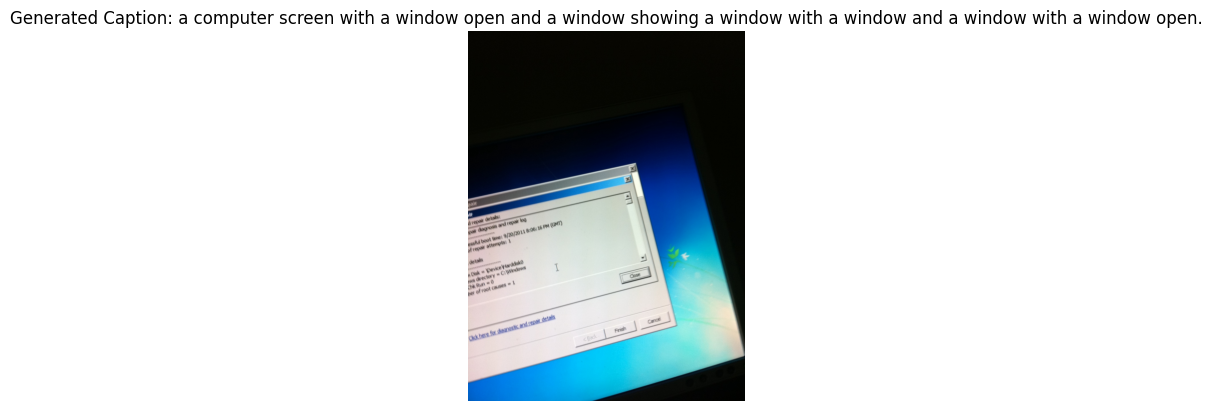

Generated Caption: a computer screen with a window open and a window showing a window with a window and a window with a window open.
Reference Caption: ['A computer screen with a windows prompt and a blue background.', 'A pop up box on a blue screen laptop background', 'A computer screen showing a diagnosis and repair log screen.', 'Two windows pop up menus designed for troubleshooting', 'A computer screen showing the image of an open window of a repair log.']
BLEU-1 score :  0.43478260867674867
METEOR score :  0.26538587013688486
ROUGE-L score :  0.43975283213182287
SPICE score :  0.20512820512820512



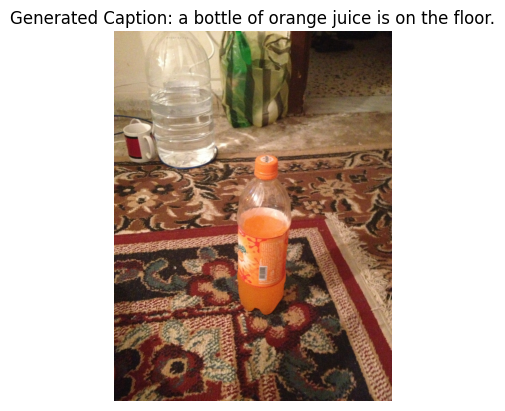

Generated Caption: a bottle of orange juice is on the floor.
Reference Caption: ['a bottle of orange soda sitting on a rug.', 'A bottle of soda sitting on a rug on the floor.', 'Sitting on an area rug are a liter of water with a mug beside it and also a small bottle of orange drink.', 'a half full bottle of orange flavored soda on a textured carpet', 'A bottle of orange soda and a bottle of water sitting on the floor near a coffee mug on a rug.']
BLEU-1 score :  0.7777777776049386
METEOR score :  0.25409561909012823
ROUGE-L score :  0.6292366637194224
SPICE score :  0.10256410256410256



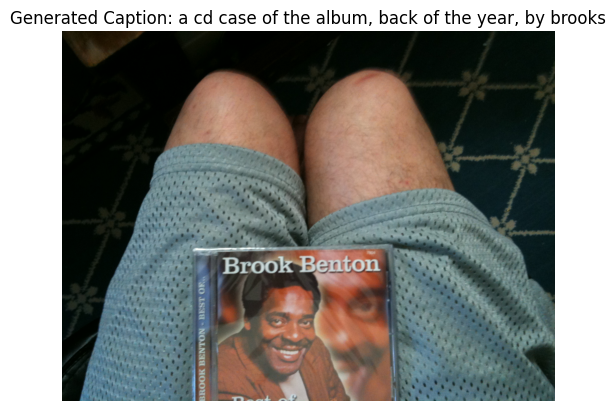

Generated Caption: a cd case of the album, back of the year, by brooks
Reference Caption: ['A cd case containing work from the artist Brook Benton', 'CD of Brook Benton sitting on the lap of a man wearing grey meshed basketball shorts', 'Someone is  placing a picture of  a smiling  man on his legs.', "A CD case of Brook Benton music sitting on a man's lap.", 'A CD of Brook Benton lays on a mans lap.']
BLEU-1 score :  0.4999999999166667
METEOR score :  0.16123870448010988
ROUGE-L score :  0.3696969696969697
SPICE score :  0.1



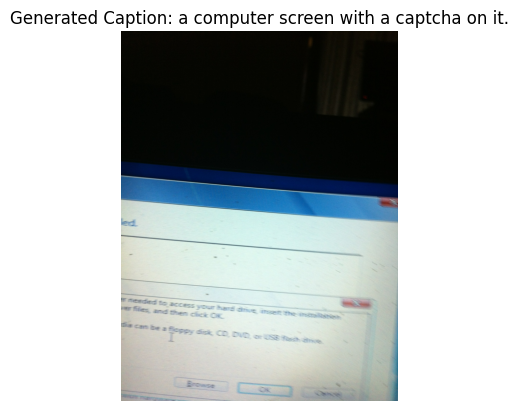

Generated Caption: a computer screen with a captcha on it.
Reference Caption: ['A laptop is open with a pop-up telling the user that they need to insert some sort of external hard drive for the internal hard drive.', 'the corner of a computer screen with installation instructions on it', 'A laptop screen is shown with a message on it against a dark background', 'Part of a computer screen that is turned on and has writing.', 'A picture of a computer screen with instructions of how to install something']
BLEU-1 score :  0.6013781187917564
METEOR score :  0.2598270992199807
ROUGE-L score :  0.6140939597315436
SPICE score :  0.05405405405405406



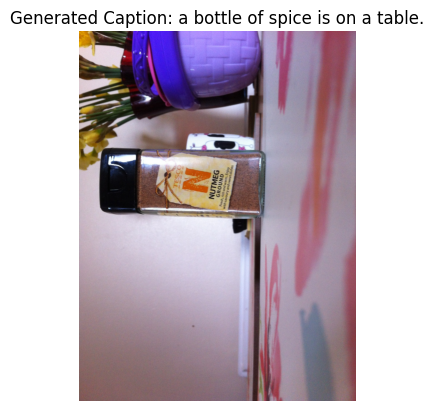

Generated Caption: a bottle of spice is on a table.
Reference Caption: ['A bottle of ground nutmeg sitting on a table.', 'A container of Nutmeg spice stands in front of a cup and a pot of flowers.', 'A bottle of ground nutmeg on the table.', 'Pictured is a small container of tesco nutmeg ground.', 'A full container of ground nutmeg sitting on a counter top.']
BLEU-1 score :  0.9999999997500004
METEOR score :  0.2840301714760885
ROUGE-L score :  0.6984732824427481
SPICE score :  0.22222222222222218



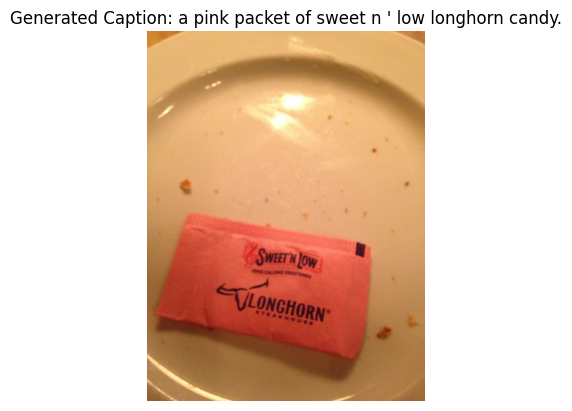

Generated Caption: a pink packet of sweet n ' low longhorn candy.
Reference Caption: ['A sweet N Low packet with the Longhorn Steakhouse logo', "A Sweet 'N Low packet rests on an empty white dinner plate.", 'I see a pink package of sweet and low  sweetener from Longhorn steakhouse.', 'A packet of Sweet And Low artificial sweetener on a plate.', 'A single package of Sweet N Low on a dirty plate.']
BLEU-1 score :  0.7954127258804594
METEOR score :  0.29969660586060437
ROUGE-L score :  0.5570776255707762
SPICE score :  0.2777777777777778



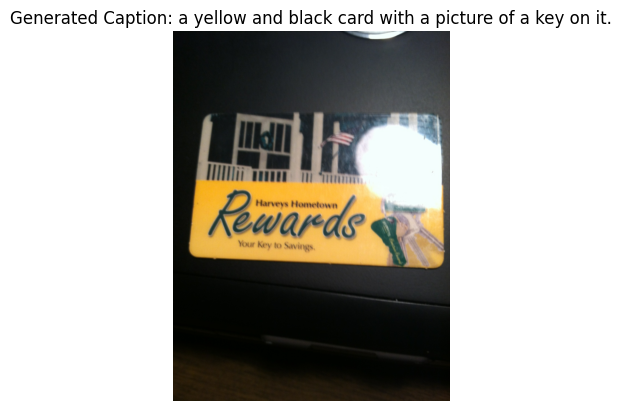

Generated Caption: a yellow and black card with a picture of a key on it.
Reference Caption: ["Rewards card for a store called Harvey's Hometown.", "shoppers' reward card that has a picture of keys and a front porch", 'a Harveys hometown reward card with some light reflection on it', 'A credit card sized rewards card for Harveys Hometown.', 'A yellow sign for a business against a white gazebo.']
BLEU-1 score :  0.8461538460236689
METEOR score :  0.16921789890566796
ROUGE-L score :  0.42302357836338417
SPICE score :  0.2105263157894737



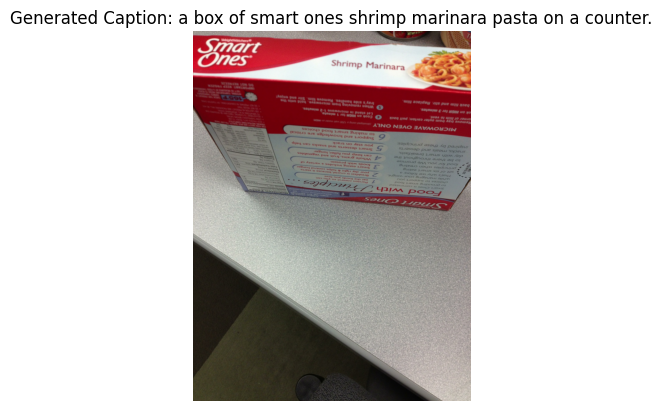

Generated Caption: a box of smart ones shrimp marinara pasta on a counter.
Reference Caption: ['A box of smart one branded food shrimp marinara on a kitchen counter.', 'The back of an upside-down box of a Smart Ones Shrimp Marinara frozen meal on top of a counter.', 'A package of food material which is placed on a tile.', 'A box of Smart Ones frozen Shrimp Marinara meal.', 'a smart ones frozen dinner box sitting on one of its edges on top of a surface']
BLEU-1 score :  0.9090909089256201
METEOR score :  0.38886783159562477
ROUGE-L score :  0.7938442470563933
SPICE score :  0.2380952380952381



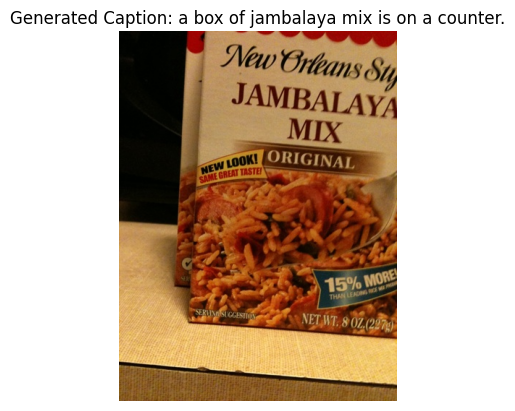

Generated Caption: a box of jambalaya mix is on a counter.
Reference Caption: ['a paper label of New Orleans Style JAMBALAYA MIX', 'cardboard boxes of New Orleans style jambalaya mix', 'A rice mix that is on the table.', 'Two cardboard boxes of jambalaya mix on top of a white surface.', 'A pack of jambalaya mix sitting on the brown table.']
BLEU-1 score :  0.6666666665185187
METEOR score :  0.2150124309870315
ROUGE-L score :  0.5213675213675214
SPICE score :  0.26666666666666666



In [ ]:
# Compare Captions generated by the fine-tuned BLIP Model with reference captions.
# Evaluate captions generated by fine-tuned BLIP Model for each image on Spice, Rouge, Meteor, Bleu and Cider scores
from aac_metrics.functional import spice
from aac_metrics.functional import rouge_l
from aac_metrics.functional import meteor
from aac_metrics.functional import bleu_1
from aac_metrics.functional import cider_d
from aac_metrics.utils.tokenization import preprocess_mono_sents, preprocess_mult_sents
import matplotlib.pyplot as plt

# Take 10 random images from the set of Test image ids
to_be_displayed_img_ids = random.sample(ids, 10)

# Function to display the results of 10 random Test set images.
def display_result(data,refCap,tbdImgIds):
  for i in tbdImgIds:
    if i in data and i in refCap:
      result_caption=[]
      result_reference_caption=[]
      image = "/content/drive/MyDrive/val/"+data[i]

      # Predicted captions using Fine-tuned BLIP model and store these captions into a list
      caption=generate_caption1(image)
      result_caption.append(caption.replace("\n", ""))

      temp_ref_cap = refCap[i]
      temp_ref_cap = [x.replace("\n", "") for x in temp_ref_cap]
      result_reference_caption.append(temp_ref_cap)
      candidates = preprocess_mono_sents(result_caption)
      mult_references = preprocess_mult_sents(result_reference_caption)
      # corpus_scores, _ = evaluate(result_caption,result_reference_caption)

      # Calculate Scores for the image
      bleu,_ = bleu_1(candidates, mult_references)
      met,_ = meteor(candidates, mult_references)
      rouge,_ = rouge_l(candidates, mult_references)
      sp,_ = spice(candidates, mult_references)
      # cd, _ = cider_d(candidates, mult_references)

      # Display image along with Reference and Generated Captions.
      img=Image.open(image).convert("RGB")
      plt.imshow(img)
      plt.axis('off')
      plt.title(f"Generated Caption: {caption}")
      plt.show()

      # Display calculated scores for the image.
      print(f"Generated Caption: {caption}")
      print(f"Reference Caption: {temp_ref_cap}")
      print("BLEU-1 score : ", bleu['bleu_1'].item())
      print("METEOR score : ", met['meteor'].item())
      print("ROUGE-L score : ", rouge['rouge_l'].item())
      # print("CIDEr score : ", cd['cider_d'].item())
      print("SPICE score : ", sp['spice'].item())
      print()

display_result(data,ref_cap,to_be_displayed_img_ids)


# ViT + GPT2

ViTs excel at processing visual data by using self-attention mechanisms, while GPT-2 is a powerful language model known for generating coherent and contextually rich text. Combining these models leverages their individual capabilities to create a highly effective image captioning framework. ViTs treat an image as a sequence of patches, allowing them to capture long-range dependencies between distant parts of the image more efficiently than CNNs. ViTs can be scaled to the size of the VizWiz dataset and can generalize well across the numerous domains of images. Once the visual features are extracted by the ViT, these embeddings need to be translated into a natural language description. GPT-2, a transformer-based language model, generates contextually rich text based on input prompts - and is ideal due to the pre-trained knowledge of language syntax. This was then fine tuned and evaluated using various performance metrics such as CIDEr, SPICE, METEOR and BLEU score.

To construct this model, some code was used from [Hugging Face](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning)


In [ ]:
import transformers
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

# Import Pre-trained ViT-GPT2 model
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

output_dir = "/content/drive/MyDrive/models/vit-gpt-model"
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/MyDrive/models/vit-gpt-model/tokenizer_config.json',
 '/content/drive/MyDrive/models/vit-gpt-model/special_tokens_map.json',
 '/content/drive/MyDrive/models/vit-gpt-model/vocab.json',
 '/content/drive/MyDrive/models/vit-gpt-model/merges.txt',
 '/content/drive/MyDrive/models/vit-gpt-model/added_tokens.json',
 '/content/drive/MyDrive/models/vit-gpt-model/tokenizer.json')

## ViT + GPT2 - Data Preprocessing
Image processing: Images are loaded and passed through ViTImageProcessor, which prepares images for input into the Vision Transformer (resizing, normalization, etc.).

Text tokenization: Captions are tokenized using AutoTokenizer with padding to a maximum length and truncation. This standardizes caption input for the decoder.

Feature Extraction: Feature extraction on image pixels is done using the ViT feature extractor.



In [ ]:
import pandas as pd
from PIL import Image

# Import the training annotations of Vizwiz dataset
vw_train = VizWiz('/content/drive/MyDrive/annotations/train.json')

loading annotations into memory...
Done (t=2.03s)
creating index...
index created! imgs = 23431, anns = 100575


In [ ]:
# Function to convert image captions to tokens
def tokenization_fn(captions, max_target_length):
    labels = tokenizer(
        captions,
        padding="max_length",
        max_length=max_target_length,
        truncation=True
        ).input_ids
    return labels

# Function to extract image features
def feature_extraction_fn(image_paths, check_image=True):
    model_inputs = {}

    if check_image:
        images = []
        to_keep = []
        for image_file in image_paths:
            try:
                img = Image.open('/content/drive/MyDrive/train/' + image_file)
                images.append(img)
                to_keep.append(True)
            except:
                to_keep.append(False)
    else:
        images = [Image.open(image_file) for image_file in image_paths]

    # Extract fetures using ViT feature Extractor
    encoder_inputs = feature_extractor(images=images, return_tensors="np")
    return encoder_inputs.pixel_values

# Pre-processing function for tokenization and feature extraction
def preprocess_fn(examples, max_target_length, check_image=True):
    image_paths = examples['image']
    captions = examples['caption']

    model_inputs = {}
    model_inputs['labels'] = tokenization_fn(captions, max_target_length)
    model_inputs['pixel_values'] = feature_extraction_fn(image_paths, check_image=check_image)

    return model_inputs

In [ ]:
# Load Vizwiz pre-processed Training Dataset
import datasets
ds = datasets.load_dataset('csv', data_files='/content/drive/MyDrive/annotations/train_data.csv')
ds.cleanup_cache_files()

{'train': 0}

In [ ]:
# Apply pre-processing (tokenization and feature extraction) to training dataset in batches
processed_dataset = ds.map(
    function=preprocess_fn,
    batched=True,
    fn_kwargs={"max_target_length": 128},
    remove_columns=ds['train'].column_names
)

processed_dataset

Map:   0%|          | 0/42212 [00:00<?, ? examples/s]

## Training/Fine-Tuning ViT + GPT2 Model

Training of the ViT + GPT2 model is done on the Vizwiz dataset using  Seq2Seq to improve the accuracy of the captions generated by the ViT+GPT2 model on the Vizwiz dataset.

Seq2SeqTrainer is used to simplify training by handling training arguments (epochs, batch size, etc.), dataset loading, pre-processing and caption generation.

The model is processed in batches using a data collator that prepare the preprocessed input for training. The created ViT feature Extractor is passed as an argument to this Trainer in order to train the model on image features present in the Vizwiz dataset.

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Use Seq2Seq Trainer to handle training argumets and generation
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    save_strategy='epoch',
    output_dir='./image-captioning-output'
)

In [ ]:
from transformers import default_data_collator

# Used Seq2Seq to handle training, feature extraction, and processing
trainer = Seq2SeqTrainer(
    model=model,
    processing_class=feature_extractor,
    args=training_args,
    train_dataset=processed_dataset['train'],
    data_collator=default_data_collator, # Data collator used to prepare input during traing
)

In [ ]:
# Train the model
trainer.train()

In [ ]:
# Save the fine-tuned model
trainer.save_model("./image-captioning-output")
tokenizer.save_pretrained("./image-captioning-output")

## ViT + GPT2 Evaluation
The fine-tuned ViT+GPT2 Model is evaluated against the Baseline model against the BLEU, METEOR, ROUGE, CIDEr, and SPICE Scores.

Captions generated by the fine-tuned ViT+GPT2 model is also comapred with the reference captions, and evaluated with the above scores.

In [ ]:
from transformers import pipeline

# Load the Baseline Vit-GPT2 model
baseline_image_captioner = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")
baseline_image_captioner.max_new_tokens = 128

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

In [ ]:
# Evaluate Baseline ViT+GPT2 Model by Calculating the BLEU, METEOR, ROUGE, CIDEr and SPICE scores, for all the generated and refernece captions in the test set.
list_reference_caption=[]
for i in ids[:100]:
  if i in data and i in ref_cap:
    image = "/content/drive/MyDrive/val/"+data[i]
    caption=baseline_image_captioner(image)
    list_caption.append(caption[0]['generated_text'].replace("\n", ""))
    temp_ref_cap = ref_cap[i]
    temp_ref_cap = [x.replace("\n", "") for x in temp_ref_cap]
    list_reference_caption.append(temp_ref_cap)

corpus_scores, _ = evaluate(list_caption,list_reference_caption)
vgpt_default_bleu_1 = corpus_scores['bleu_1'].item()
vgpt_default_meteor = corpus_scores['meteor'].item()
vgpt_default_rouge_l =corpus_scores['rouge_l'].item()
vgpt_default_cider_d =corpus_scores['cider_d'].item()
vgpt_default_spice = corpus_scores['spice'].item()
print("BLEU-1 score for default ViT + GPT2 model: ", corpus_scores['bleu_1'].item())
print("BLEU-2 score for default ViT + GPT2 model: ", corpus_scores['bleu_2'].item())
print("BLEU-3 score for default ViT + GPT2 model: ", corpus_scores['bleu_3'].item())
print("BLEU-4 score for default ViT + GPT2 model: ", corpus_scores['bleu_4'].item())
print("METEOR score for default ViT + GPT2 model: ", corpus_scores['meteor'].item())
print("ROUGE-L score for default ViT + GPT2 model: ", corpus_scores['rouge_l'].item())
print("CIDEr score for default ViT + GPT2 model: ", corpus_scores['cider_d'].item())
print("SPICE score for default ViT + GPT2 model: ", corpus_scores['spice'].item())

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


BLEU-1 score for default ViT + GPT2 model:  0.6049223131755451
BLEU-2 score for default ViT + GPT2 model:  0.4001583909791953
BLEU-3 score for default ViT + GPT2 model:  0.24873400924040578
BLEU-4 score for default ViT + GPT2 model:  0.1549533036887009
METEOR score for default ViT + GPT2 model:  0.16056834432513536
ROUGE-L score for default ViT + GPT2 model:  0.398358093376239
CIDEr score for default ViT + GPT2 model:  0.20526172854126018
SPICE score for default ViT + GPT2 model:  0.08399369709237668


In [ ]:
# Import the fine-tuned ViT-GPT2 model
from transformers import pipeline
image_captioner = pipeline("image-to-text", model="/content/drive/MyDrive/models/vit_gpt_fine_tuned")
image_captioner.max_new_tokens = 128

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

In [ ]:
# Creating a list of Test data image ids and captions from pre-processed test annotations
eval_data=pd.read_csv('/content/drive/MyDrive/annotations/val_data_2k.csv')
samples=[]
ids=[]
data={}
ref_cap={}

# Create a list containing Ids, Captions, and Filenames of the 2000 test images
for _, row in eval_data.iterrows():
                samples.append({
                    "id":row['id'],
                    "caption": row["caption"],
                    "file_name": row["file_name"]
                })

# Map Id to captions to create a list of the original reference captions
for e in samples:
    if e['id'] in ref_cap:
      ref_cap[e['id']].append(e['caption'])
    else:
      ref_cap[e['id']]=[e['caption']]
    if e['id'] not in data:
      data[e['id']]=e['file_name']
      ids.append(e['id'])


# Evaluate fine-tuned ViT+GPT2 Model by Calculating the BLEU, METEOR, ROUGE, CIDEr and SPICE scores, for all generated and reference captions in the test set.
list_caption=[]
list_reference_caption=[]
for i in ids[:100]:
  if i in data and i in ref_cap:
    image = "/content/drive/MyDrive/val/"+data[i]
    caption=image_captioner(image)
    list_caption.append(caption[0]['generated_text'].replace("\n", ""))
    temp_ref_cap = ref_cap[i]
    temp_ref_cap = [x.replace("\n", "") for x in temp_ref_cap]
    list_reference_caption.append(temp_ref_cap)


corpus_scores, _ = evaluate(list_caption,list_reference_caption)
vgpt_fine_tuned_bleu_1 = corpus_scores['bleu_1'].item()
vgpt_fine_tuned_meteor = corpus_scores['meteor'].item()
vgpt_fine_tuned_rouge_l =corpus_scores['rouge_l'].item()
vgpt_fine_tuned_cider_d =corpus_scores['cider_d'].item()
vgpt_fine_tuned_spice = corpus_scores['spice'].item()
print("BLEU-1 score for fine-tuned ViT + GPT2 model: ", corpus_scores['bleu_1'].item())
print("BLEU-2 score for fine-tuned ViT + GPT2 model: ", corpus_scores['bleu_2'].item())
print("BLEU-3 score for fine-tuned ViT + GPT2 model: ", corpus_scores['bleu_3'].item())
print("BLEU-4 score for fine-tuned ViT + GPT2 model: ", corpus_scores['bleu_4'].item())
print("METEOR score for fine-tuned ViT + GPT2 model: ", corpus_scores['meteor'].item())
print("ROUGE-L score for fine-tuned ViT + GPT2 model: ", corpus_scores['rouge_l'].item())
print("CIDEr score for fine-tuned ViT + GPT2 model: ", corpus_scores['cider_d'].item())
print("SPICE score for fine-tuned ViT + GPT2 model: ", corpus_scores['spice'].item())

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


BLEU-1 score for fine-tuned ViT + GPT2 model:  0.6439393939387842
BLEU-2 score for fine-tuned ViT + GPT2 model:  0.46426777511321266
BLEU-3 score for fine-tuned ViT + GPT2 model:  0.32313899609742475
BLEU-4 score for fine-tuned ViT + GPT2 model:  0.22156952141904118
METEOR score for fine-tuned ViT + GPT2 model:  0.19844782813704645
ROUGE-L score for fine-tuned ViT + GPT2 model:  0.4494194543917407
CIDEr score for fine-tuned ViT + GPT2 model:  0.4243760949742443
SPICE score for fine-tuned ViT + GPT2 model:  0.12412534181108818


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


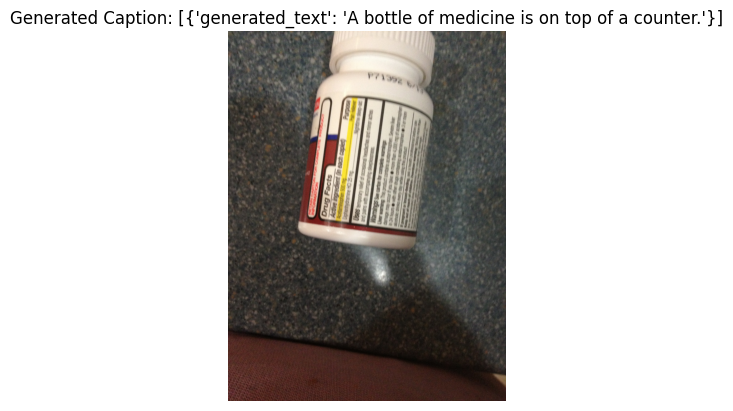

Generated Caption: [{'generated_text': 'A bottle of medicine is on top of a counter.'}]
Reference Caption: ['A bottle laying on the counter with the back label showing.', 'A small bottle of over the counter medicine is laying on a grey countertop.', 'A bottle of acetaminophen is on its side on a counter.', 'a white pill container which has acetaminophen inside', 'A small bottle of medicine on a counter showing the drug facts portion of the label.']
BLEU-1 score :  0.814353676069493
METEOR score :  0.2880001163410544
ROUGE-L score :  0.6609907120743034
SPICE score :  0.2285714285714286



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


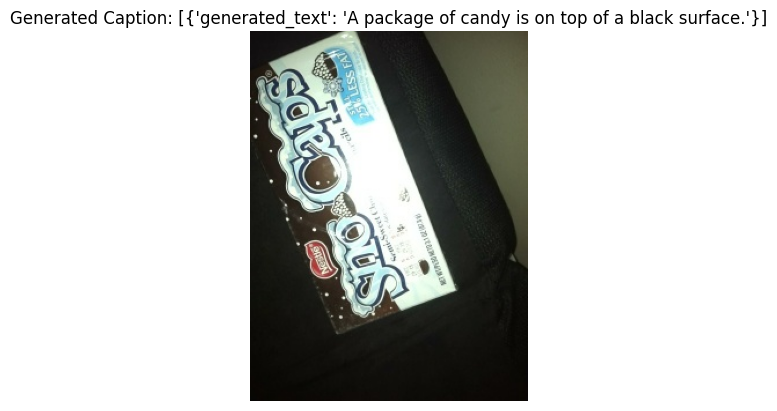

Generated Caption: [{'generated_text': 'A package of candy is on top of a black surface.'}]
Reference Caption: ['A brown and white box of sno caps candy.', 'Chocolate treats are in the box on the chair and I think we deserve them.', 'A box of Sno Caps chocolate with white nonpareils candy.', 'A famous and tasty Nestle company product is shown.', 'Nestle Sno Caps candy sitting on a cushion.']
BLEU-1 score :  0.4545454545041323
METEOR score :  0.15277387856431598
ROUGE-L score :  0.32504440497335696
SPICE score :  0.13793103448275862



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


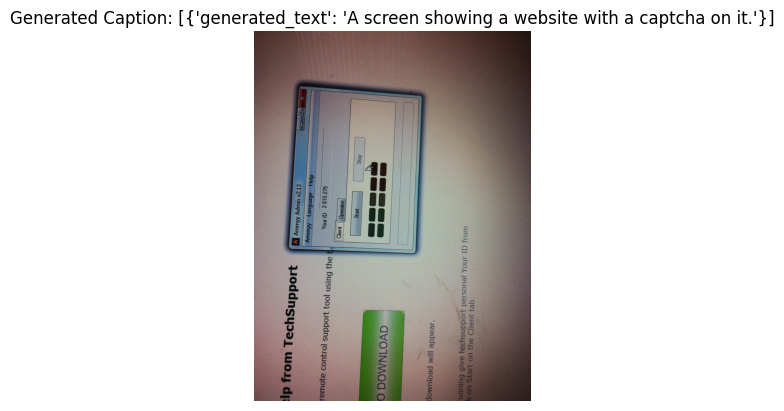

Generated Caption: [{'generated_text': 'A screen showing a website with a captcha on it.'}]
Reference Caption: ['A section of a computer screen with a pop up box running an administration program.', 'A computer screen has a settings menu loaded in front of a tech support window.', 'A computer screen showing a tech support page.', 'A computer screen for tech support on a computer.', 'A part of a computer screen that shows some tips from Tech support.']
BLEU-1 score :  0.6999999999300001
METEOR score :  0.19397752772480223
ROUGE-L score :  0.4535315985130111
SPICE score :  0.0625



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


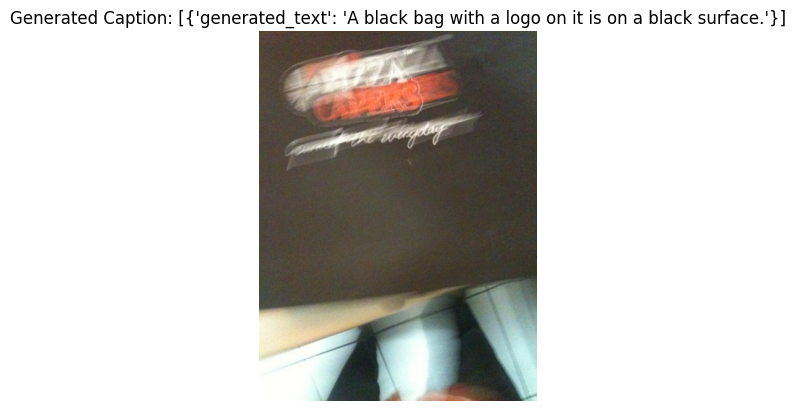

Generated Caption: [{'generated_text': 'A black bag with a logo on it is on a black surface.'}]
Reference Caption: ['A black sheet of paper displays the logo of a pizza place.', 'A white and red lighted pizza sign that is possibly part of a motion photo', 'This appears to be an advertisement for pizza capers but is extremely blurry.', 'a red and white pizza capers logo on a black box', 'A white and orange logo for something called "Pizza Capers"']
BLEU-1 score :  0.46153846146745575
METEOR score :  0.1669816017078484
ROUGE-L score :  0.42302357836338417
SPICE score :  0.04878048780487805



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


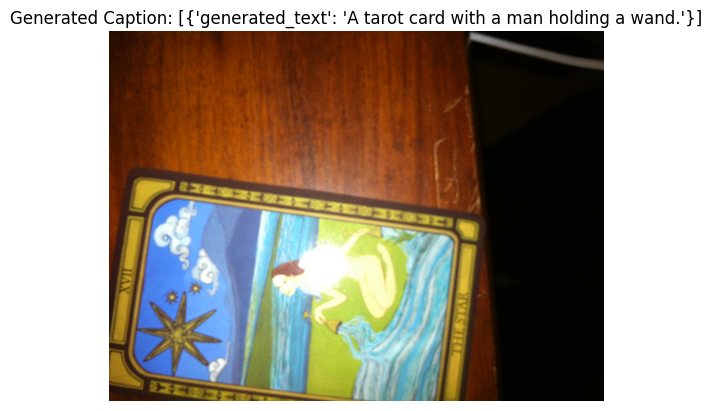

Generated Caption: [{'generated_text': 'A tarot card with a man holding a wand.'}]
Reference Caption: ['A card with the word The Star has a woman on it.', 'C playing card with a woman, and a goblet dumping out into a river, labeled XVII the star.', 'A card that has the star written on the bottom with an illustrated woman on the beach in the middle and XVII on the top.', 'A painting of a woman on a beach looking at the sun.', 'a tarot card the star sitting on the table']
BLEU-1 score :  0.6666666665185187
METEOR score :  0.19097291792668583
ROUGE-L score :  0.3713850837138508
SPICE score :  0.10256410256410256



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


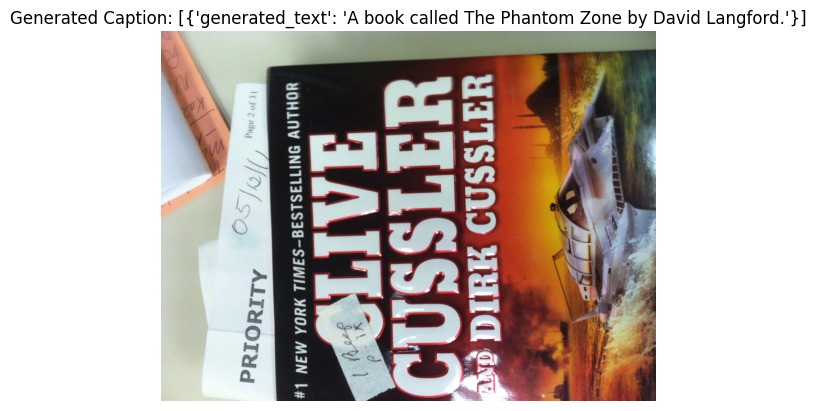

Generated Caption: [{'generated_text': 'A book called The Phantom Zone by David Langford.'}]
Reference Caption: ['A hardcover novel from Clive Cussler and Dirk Cussler.', 'A book with the text "Clive Cussler and Dirk Cussler" with an image of a sci-fi boat.', 'Top of a Clive Cussler and Dirk Cussler book with title not showing.', 'The front of a book by Clive Cussler is shown with pages sticking out of it.', 'the cover of a book by author Clive Cussler']
BLEU-1 score :  0.4444444443456792
METEOR score :  0.13478160411079548
ROUGE-L score :  0.3333333333333333
SPICE score :  0.05714285714285715



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


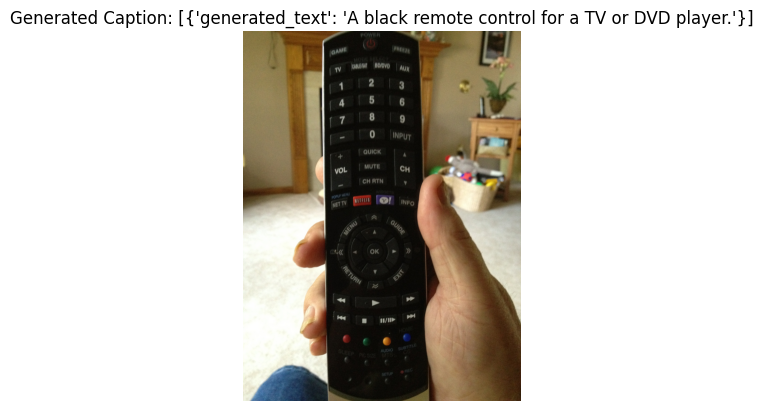

Generated Caption: [{'generated_text': 'A black remote control for a TV or DVD player.'}]
Reference Caption: ['A TV remote is being held by a human hand with a portion of the room in the background.', 'You are holding a remote control for cable television in your hands.', 'Somebody is holding up a black TV remote.', 'A universal remote control with a Netflix and yahoo button.', "A black remote control with several buttons held in someone's hand."]
BLEU-1 score :  0.6999999998600002
METEOR score :  0.2841256667506519
ROUGE-L score :  0.4
SPICE score :  0.17142857142857143



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


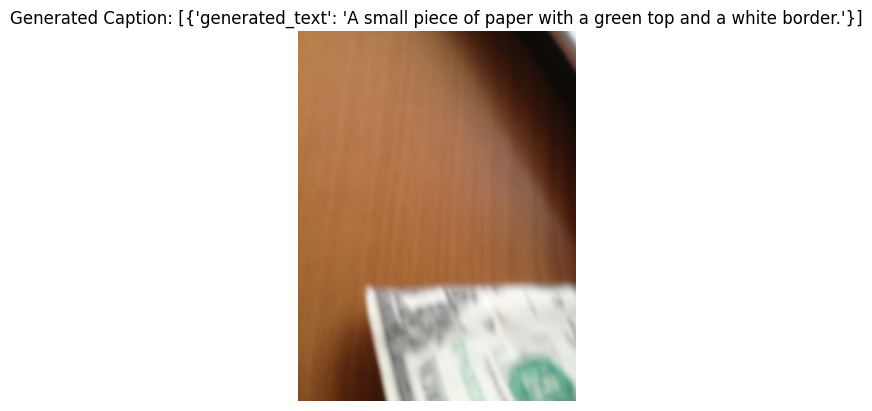

Generated Caption: [{'generated_text': 'A small piece of paper with a green top and a white border.'}]
Reference Caption: ['A table with a US one dollar bill sitting on it.', 'a very blurry one dollar bill over wooden floor or table.', 'Pictured is a $1 bill laying on a table.', 'Crumpled single United States Of America dollar bill on a desk.', 'A one dollar bill is on top of a table.']
BLEU-1 score :  0.38461538458579886
METEOR score :  0.12403100775193797
ROUGE-L score :  0.2671532846715329
SPICE score :  0.05714285714285714



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


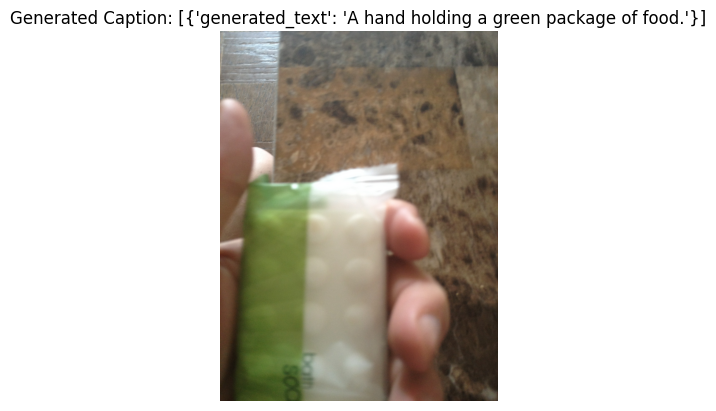

Generated Caption: [{'generated_text': 'A hand holding a green package of food.'}]
Reference Caption: ['A person is holding a candy bar in his hand.', "A small package of soap held in someone's hand", 'A person is holding a package of bath salts.', 'A half green have white packaged soap on a bathroom counter', 'A person holding a white and green plastic covered medicine']
BLEU-1 score :  0.772184789568475
METEOR score :  0.21880347809993925
ROUGE-L score :  0.5820610687022901
SPICE score :  0.05555555555555555



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


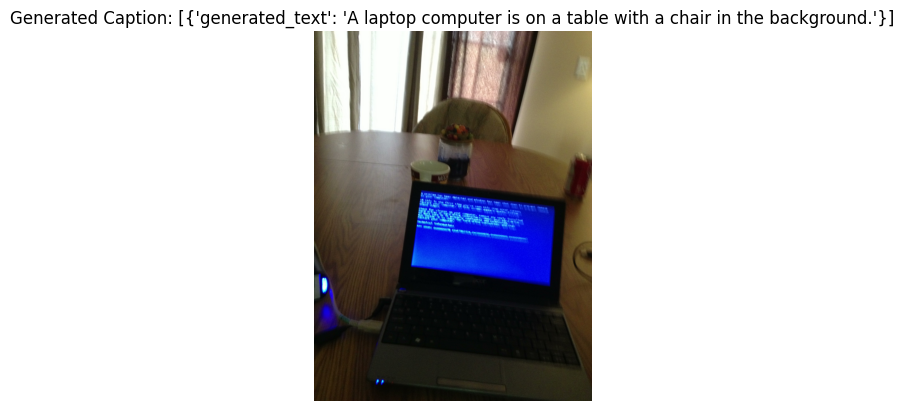

Generated Caption: [{'generated_text': 'A laptop computer is on a table with a chair in the background.'}]
Reference Caption: ['an electronic product used in all offices and can take wherever you go and can work', 'A laptop displaying a blue screen with white text is on the table.', 'A laptop computer is on a wooden table.', 'A problem was detected on your computer according to the text and it has been shut down.', 'An open laptop is powered up on top of a table.']
BLEU-1 score :  0.7692307691124263
METEOR score :  0.4063759399355348
ROUGE-L score :  0.696574225122349
SPICE score :  0.25806451612903225



In [ ]:
# Display Reference and fine-tuned ViT-GPT2 Generated caption for each image and also evaluate Model on Spice, Rouge, Meteor, Bleu and Cider scores
from aac_metrics.functional import spice
from aac_metrics.functional import rouge_l
from aac_metrics.functional import meteor
from aac_metrics.functional import bleu_1
from aac_metrics.functional import cider_d
from aac_metrics.utils.tokenization import preprocess_mono_sents, preprocess_mult_sents
import matplotlib.pyplot as plt

# Take 10 random images from the set of Test image ids
to_be_displayed_img_ids = random.sample(ids, 10)

# Function to display the results of 10 random Test set images.
def display_result(data,refCap,tbdImgIds):
  for i in tbdImgIds:
    if i in data and i in refCap:
      result_caption=[]
      result_reference_caption=[]
      image = "/content/drive/MyDrive/val/"+data[i]

      # Predicted captions using Fine-tuned ViT-GPT2 model and store these captions into a list
      caption=image_captioner(image)
      result_caption.append(caption[0]['generated_text'].replace("\n", ""))

      temp_ref_cap = refCap[i]
      temp_ref_cap = [x.replace("\n", "") for x in temp_ref_cap]
      result_reference_caption.append(temp_ref_cap)
      candidates = preprocess_mono_sents(result_caption)
      mult_references = preprocess_mult_sents(result_reference_caption)
      # corpus_scores, _ = evaluate(result_caption,result_reference_caption)

      # Calculate Scores for the image
      bleu,_ = bleu_1(candidates, mult_references)
      met,_ = meteor(candidates, mult_references)
      rouge,_ = rouge_l(candidates, mult_references)
      sp,_ = spice(candidates, mult_references)
      # cd, _ = cider_d(candidates, mult_references)

      # Display image along with Reference and Generated Captions.
      img=Image.open(image).convert("RGB")
      plt.imshow(img)
      plt.axis('off')
      plt.title(f"Generated Caption: {caption}")
      plt.show()

      # Display calculated scores for the image.
      print(f"Generated Caption: {caption}")
      print(f"Reference Caption: {temp_ref_cap}")
      print("BLEU-1 score : ", bleu['bleu_1'].item())
      print("METEOR score : ", met['meteor'].item())
      print("ROUGE-L score : ", rouge['rouge_l'].item())
      # print("CIDEr score : ", cd['cider_d'].item())
      print("SPICE score : ", sp['spice'].item())
      print()

display_result(data,ref_cap,to_be_displayed_img_ids)


# Comparing Results of Various Models
The results of the fine-tuned BLIP and ViT-GPT2 models are compared with the Pre-trained Baseline Blip Model and ViT-GPT2 models repectively. The models performance are compared against BLEU, METEOR, ROGUE, CIDEr and SPICE score.

Overall it can be seen that the Fine-tuned Models performs better than the Baseline model. For image captioning tasks, CIDEr score is generally considered a strong indicator of the model's performance. The high CIDEr score of the Fine-tuned BLIP model, shows that fine-tuning the BLIP model has positively impacted the model's ability to generate captions that align well with given reference captions.

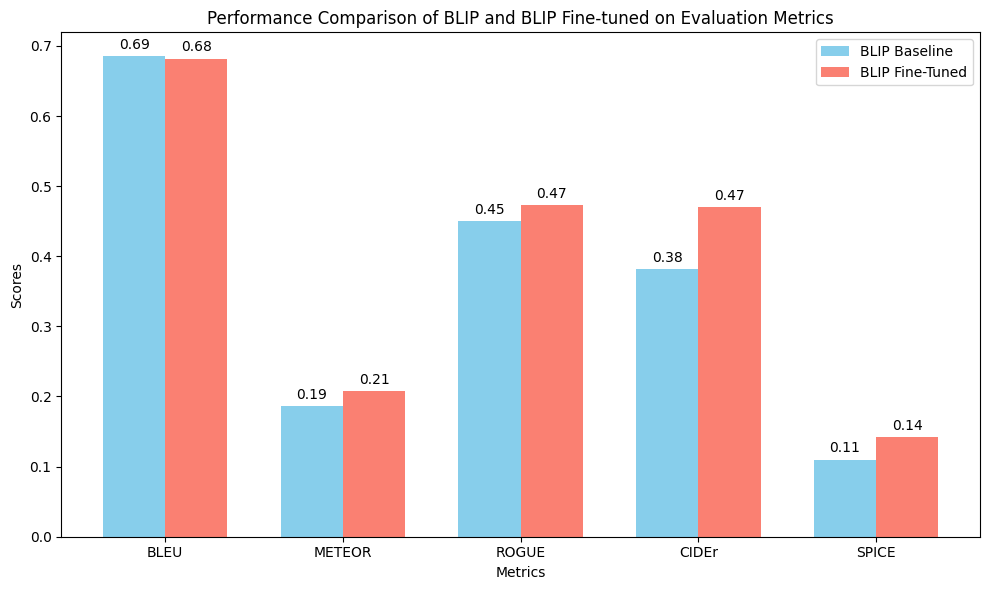

In [ ]:
# Plot Graph between Baseline (Pre-trained) BLIP Model and the Trained (Fine-tuned) BLIP Model
import numpy as np
import matplotlib.pyplot as plt

# Store Scores for the Baseline Blip Model into a list
blip_baseline_score = []
blip_baseline_score.append(blip_baseline_bleu_1)
blip_baseline_score.append(blip_baseline_meteor)
blip_baseline_score.append(blip_baseline_rouge_l)
blip_baseline_score.append(blip_baseline_cider_d)
blip_baseline_score.append(blip_baseline_spice)

# Store Scores for fine-tuned BLIP Model into a list
blip_fine_tuned_score=[]
blip_fine_tuned_score.append(blip_fine_tuned_bleu_1)
blip_fine_tuned_score.append(blip_fine_tuned_meteor)
blip_fine_tuned_score.append(blip_fine_tuned_rouge_l)
blip_fine_tuned_score.append(blip_fine_tuned_cider_d)
blip_fine_tuned_score.append(blip_fine_tuned_spice)


# Metric/Score labels for the graphs
metrics = ['BLEU', 'METEOR','ROGUE', 'CIDEr','SPICE']

# Set up bar locations and width
x = np.arange(len(metrics))
width = 0.35

# Plotting the bar chart for Baseline and Fine-tuned BLIP
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, blip_baseline_score, width, label='BLIP Baseline', color='skyblue')
rects2 = ax.bar(x + width/2, blip_fine_tuned_score, width, label='BLIP Fine-Tuned', color='salmon')

# Set Labels and titles
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of BLIP and BLIP Fine-tuned on Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add value labels above bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text above bars
                    textcoords="offset points",
                    ha='center', va='bottom')

# Apply labels to each set of bars
add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


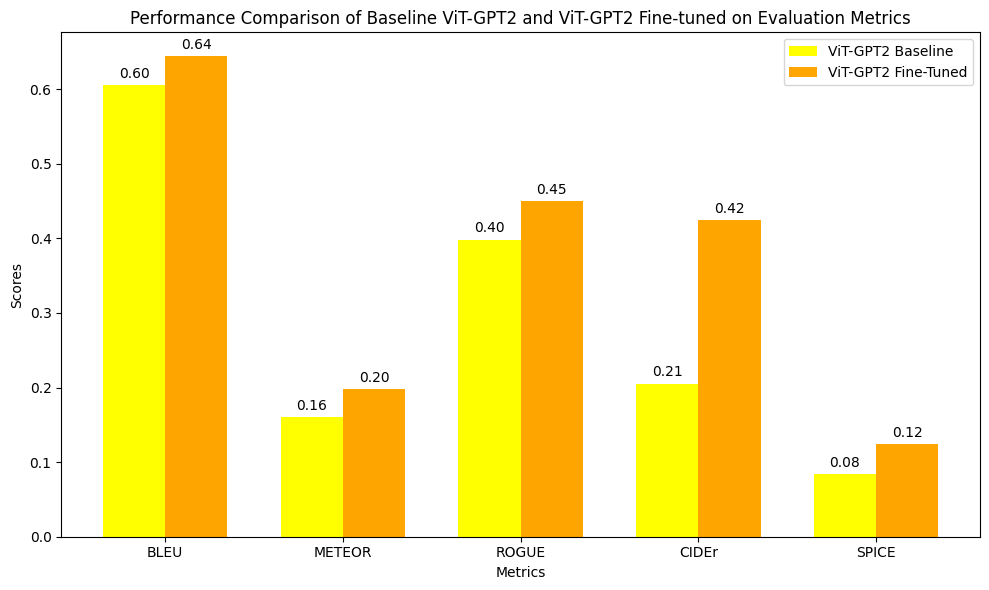

In [ ]:
# Plot Graph between Fine-tuned ViT-GPT2 Model and the Fine-tuned ViT-GPT2 Model
import numpy as np
import matplotlib.pyplot as plt

# Store Scores for the Baseline ViT-GPT2 Model into a list
vitgpt_baseline_score = []
vitgpt_baseline_score.append(vgpt_default_bleu_1)
vitgpt_baseline_score.append(vgpt_default_meteor)
vitgpt_baseline_score.append(vgpt_default_rouge_l)
vitgpt_baseline_score.append(vgpt_default_cider_d)
vitgpt_baseline_score.append(vgpt_default_spice)

# Store Scores for fine-tuned ViT-GPT2 Model into a list
vitgpt_fine_tuned_score=[]
vitgpt_fine_tuned_score.append(vgpt_fine_tuned_bleu_1)
vitgpt_fine_tuned_score.append(vgpt_fine_tuned_meteor)
vitgpt_fine_tuned_score.append(vgpt_fine_tuned_rouge_l)
vitgpt_fine_tuned_score.append(vgpt_fine_tuned_cider_d)
vitgpt_fine_tuned_score.append(vgpt_fine_tuned_spice)

# Metric/Score labels for the graphs
metrics = ['BLEU', 'METEOR','ROGUE', 'CIDEr','SPICE']

# Set up bar locations and width
x = np.arange(len(metrics))
width = 0.35

# Plotting the bar chart for Baseline and Fine-tuned ViT-GPT2
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, vitgpt_baseline_score, width, label='ViT-GPT2 Baseline', color='yellow')
rects2 = ax.bar(x + width/2, vitgpt_fine_tuned_score, width, label='ViT-GPT2 Fine-Tuned', color='orange')

# Set Labels and titles
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Baseline ViT-GPT2 and ViT-GPT2 Fine-tuned on Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add value labels above bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text above bars
                    textcoords="offset points",
                    ha='center', va='bottom')

# Apply labels to each set of bars
add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


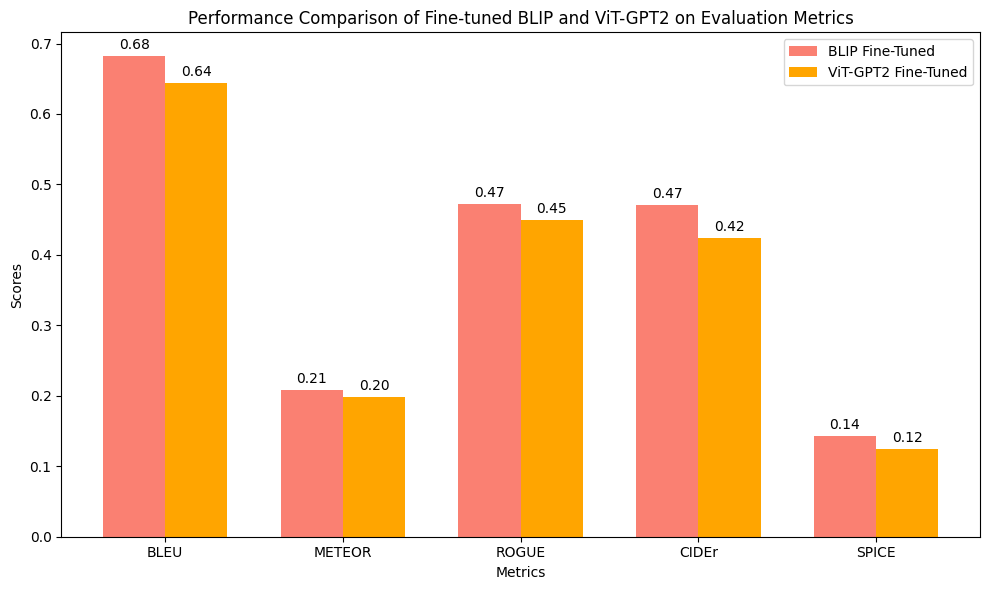

In [ ]:
# Plot Graph between Fine-tuned BLIP Model and the Fine-tuned ViT-GPT2 Model
import numpy as np
import matplotlib.pyplot as plt


# Metric/Score labels for the graphs
metrics = ['BLEU', 'METEOR','ROGUE', 'CIDEr','SPICE']

# Set up bar locations and width
x = np.arange(len(metrics))
width = 0.35

# Plotting the bar chart for Fine-tuned BLIP and ViT-GPT2 Models
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, blip_fine_tuned_score, width, label='BLIP Fine-Tuned', color='salmon')
rects2 = ax.bar(x + width/2, vitgpt_fine_tuned_score, width, label='ViT-GPT2 Fine-Tuned', color='orange')

# Set Labels and titles
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Fine-tuned BLIP and ViT-GPT2 on Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add value labels above bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text above bars
                    textcoords="offset points",
                    ha='center', va='bottom')

# Apply labels to each set of bars
add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Define the scores for each model
metrics = ['BLEU-1', 'METEOR', 'ROUGE', 'CIDEr', 'SPICE']

# Create a dictionary with the data for the table
data = {
    "Model": ["Baseline BLIP", "Fine-tuned BLIP", "Baseline ViT+GPT2", "Fine-tuned ViT+GPT2"],
    "BLEU-1": [blip_baseline_score[0], blip_fine_tuned_score[0], vitgpt_baseline_score[0], vitgpt_fine_tuned_score[0]],
    "METEOR": [blip_baseline_score[1], blip_fine_tuned_score[1], vitgpt_baseline_score[1], vitgpt_fine_tuned_score[1]],
    "ROUGE": [blip_baseline_score[2], blip_fine_tuned_score[2], vitgpt_baseline_score[2], vitgpt_fine_tuned_score[2]],
    "CIDEr": [blip_baseline_score[3], blip_fine_tuned_score[3], vitgpt_baseline_score[3], vitgpt_fine_tuned_score[3]],
    "SPICE": [blip_baseline_score[4], blip_fine_tuned_score[4], vitgpt_baseline_score[4], vitgpt_fine_tuned_score[4]]
}

# Convert the dictionary into a pandas DataFrame
df_scores = pd.DataFrame(data)

# Print the DataFrame
print(df_scores)

                 Model    BLEU-1    METEOR     ROUGE     CIDEr     SPICE
0        Baseline BLIP  0.685067  0.185976  0.450139  0.381909  0.110000
1      Fine-tuned BLIP  0.681776  0.208076  0.472461  0.470270  0.142570
2    Baseline ViT+GPT2  0.604922  0.160568  0.398358  0.205262  0.083994
3  Fine-tuned ViT+GPT2  0.643939  0.198448  0.449419  0.424376  0.124125


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


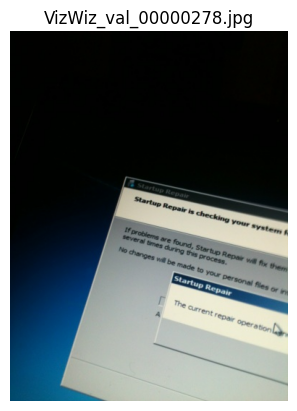

BLIP Baseline
Generated Caption: ['a computer screen with a message on it']
Reference Caption: [['a computer screen going through a troubleshooting startup repair application', 'a computer screen with a message about startup repair', 'startup repair window for a systems check on the computer', 'a windows dialogue box for startup repair and a mouse cursor point to a middle message', 'pointer is on the startup repair of a windows computer']]
BLEU-1 score :  0.772184789568475
METEOR score :  0.37069267684058677
ROUGE-L score :  0.6984732824427481
SPICE score :  0.2352941176470588


BLIP Fine-Tuned
Generated Caption: ['a computer screen with a startup repair window open']
Reference Caption: [['a computer screen going through a troubleshooting startup repair application', 'a computer screen with a message about startup repair', 'startup repair window for a systems check on the computer', 'a windows dialogue box for startup repair and a mouse cursor point to a middle message', 'pointer is on

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


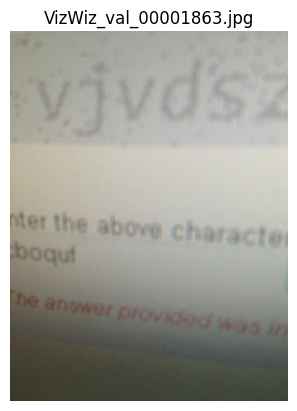

BLIP Baseline
Generated Caption: ['a computer screen with a message on it']
Reference Caption: [['a captcha code on a website with black font', 'computer screen showing a captcha test where someone gave the wrong answer', 'zoomed in picture of a captcha on a computer screen which the captcha attempt was incorrect', 'words and other letters being displayed on what looks to be a computer monitor', 'text is displayed on the screen of a computer']]
BLEU-1 score :  0.6618726767729786
METEOR score :  0.20956978524377465
ROUGE-L score :  0.28955696202531644
SPICE score :  0.12121212121212122


BLIP Fine-Tuned
Generated Caption: ['a computer screen with a white background and a red text']
Reference Caption: [['a captcha code on a website with black font', 'computer screen showing a captcha test where someone gave the wrong answer', 'zoomed in picture of a captcha on a computer screen which the captcha attempt was incorrect', 'words and other letters being displayed on what looks to be a comput

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


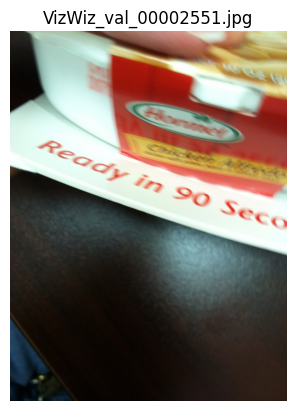

BLIP Baseline
Generated Caption: ['a person is holding a box of food']
Reference Caption: [['a hormel brand chicken alfredo flavor packaged meal', 'a box of food is sitting on a black table', 'a package of some sort of meat or dinner', 'a close up of a container of hormel instant meal', 'a box of ready in 90 seconds hormel chicken alfredo']]
BLEU-1 score :  0.7499999998125003
METEOR score :  0.24622147526924
ROUGE-L score :  0.43571428571428567
SPICE score :  0.18181818181818182


BLIP Fine-Tuned
Generated Caption: ['a package of ready in 90 seconds noodles is on top of a table']
Reference Caption: [['a hormel brand chicken alfredo flavor packaged meal', 'a box of food is sitting on a black table', 'a package of some sort of meat or dinner', 'a close up of a container of hormel instant meal', 'a box of ready in 90 seconds hormel chicken alfredo']]
BLEU-1 score :  0.8571428570816327
METEOR score :  0.3473756791959286
ROUGE-L score :  0.5154929577464789
SPICE score :  0.21621621621621623

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


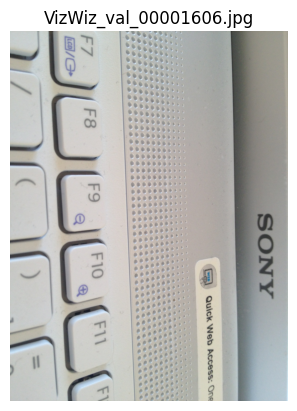

BLIP Baseline
Generated Caption: ['a close up of a keyboard with a white key']
Reference Caption: [['a sony laptop keyboard with its speakers above it', 'a white colored sony laptop computer with quick web access written on it', 'just a few of the top keys on a keyboard and the word sony at the top', 'the f keys of a white sony computer keyboard', 'a grey sony laptop with the f row of keys displayed']]
BLEU-1 score :  0.5999999999400001
METEOR score :  0.16877761293355087
ROUGE-L score :  0.3577712609970674
SPICE score :  0.10256410256410256


BLIP Fine-Tuned
Generated Caption: ['a white sony laptop keyboard with a white keypad']
Reference Caption: [['a sony laptop keyboard with its speakers above it', 'a white colored sony laptop computer with quick web access written on it', 'just a few of the top keys on a keyboard and the word sony at the top', 'the f keys of a white sony computer keyboard', 'a grey sony laptop with the f row of keys displayed']]
BLEU-1 score :  0.7777777776049386


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


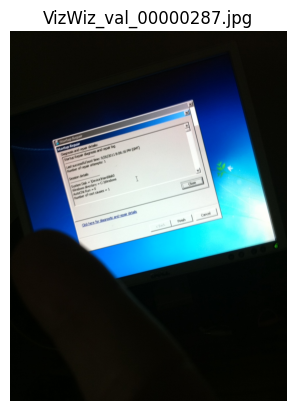

BLIP Baseline
Generated Caption: ['a person is holding a tablet with a screen showing a message']
Reference Caption: [['the screen of a computer showing a startup repair prompt', 'a screenshot of a computer monitor with a startup repair warning', 'windows startup repairdiagnosis and repair details loglast successful boot time 9/20/2011 8:06:16 pm -lrb- gmt -rrb-', 'a blue and white computer screen with a startup repair screen on the background', 'a computer screen is shown that has a gray box on the screen']]
BLEU-1 score :  0.5833333332847223
METEOR score :  0.15946500525999305
ROUGE-L score :  0.3505747126436781
SPICE score :  0.046511627906976744


BLIP Fine-Tuned
Generated Caption: ['a computer screen with a blue background and a white window']
Reference Caption: [['the screen of a computer showing a startup repair prompt', 'a screenshot of a computer monitor with a startup repair warning', 'windows startup repairdiagnosis and repair details loglast successful boot time 9/20/2011 8

In [ ]:
# Compare predicted captions and scores for all Models on sample images
from aac_metrics.functional import rouge_l
from aac_metrics.functional import meteor
from aac_metrics.functional import bleu_1
from aac_metrics.functional import cider_d
from aac_metrics.utils.tokenization import preprocess_mono_sents, preprocess_mult_sents
import matplotlib.pyplot as plt

# Take random images from the set of Test image ids
to_be_displayed_img_ids = random.sample(ids, 5)


def calculate_scores(model_name,caption,mult_references):
  result_caption = []
  if "BLIP" in  model_name:
    result_caption.append(caption.replace("\n", ""))
  else:
    result_caption.append(caption[0]['generated_text'].replace("\n", ""))

  candidates = preprocess_mono_sents(result_caption)
  # corpus_scores, _ = evaluate(result_caption,result_reference_caption)

  # Calculate Scores for the image
  bleu,_ = bleu_1(candidates, mult_references)
  met,_ = meteor(candidates, mult_references)
  rouge,_ = rouge_l(candidates, mult_references)
  sp,_ = spice(candidates, mult_references)
  # cd, _ = cider_d(candidates, mult_references)

  # Display calculated scores for the image.
  print(model_name)
  print(f"Generated Caption: {candidates}")
  print(f"Reference Caption: {mult_references}")
  print("BLEU-1 score : ", bleu['bleu_1'].item())
  print("METEOR score : ", met['meteor'].item())
  print("ROUGE-L score : ", rouge['rouge_l'].item())
  # print("CIDEr score : ", cd['cider_d'].item())
  print("SPICE score : ", sp['spice'].item())
  print("\n")

# Function to display the generated captions and scores of random Test set images for all models
def display_result(data,refCap,tbdImgIds):
  for i in tbdImgIds:
    if i in data and i in refCap:
      result_caption=[]
      result_reference_caption=[]
      image = "/content/drive/MyDrive/val/"+data[i]

      # Predicted captions using Fine-tuned BLIP model and store these captions into a list
      blip_baseline_caption=generate_caption(image)
      blip_finetuned_caption=generate_caption1(image)
      vitgpt_baseline_caption=baseline_image_captioner(image)
      vitgpt_finetuned_caption=image_captioner(image)
      # result_caption.append(caption.replace("\n", ""))

      temp_ref_cap = refCap[i]
      temp_ref_cap = [x.replace("\n", "") for x in temp_ref_cap]
      result_reference_caption.append(temp_ref_cap)
      # candidates = preprocess_mono_sents(result_caption)
      mult_references = preprocess_mult_sents(result_reference_caption)
      # corpus_scores, _ = evaluate(result_caption,result_reference_caption)


      # Display image along with Reference and Generated Captions.
      img=Image.open(image).convert("RGB")
      plt.imshow(img)
      plt.axis('off')
      plt.title(f"{data[i]}")
      plt.show()

      calculate_scores("BLIP Baseline",blip_baseline_caption,mult_references)
      calculate_scores("BLIP Fine-Tuned",blip_finetuned_caption,mult_references)
      calculate_scores("Vit+GPT2 Baseline",vitgpt_baseline_caption,mult_references)
      calculate_scores("Vit+GPT2 Fine-tuned",vitgpt_finetuned_caption,mult_references)

display_result(data,ref_cap,to_be_displayed_img_ids)

